# Biomass reference map generation for the Canal Zone, Panama

This workflow is a demonstration of one possible approach for creating aboveground biomass reference maps in R using airborne laser scanning (ALS) and field plot inventory data collected over plots located across the Canal Zone in central Panama.

### Extending field inventories with airborne lidar
Using local relationships between forest inventory data and ALS, this workflow (i) demonstrates ALS processing and registration to field data, (ii) compares independent results from different users of the same data, and (iii) produces biomass reference maps for large areas of forest. Users of this workflow will:

1. Prepare the workspace.
2. Access the ALS data and read it into a workspace.
3. Process the ALS data to produce terrain and canopy products.
4. Access the field plot data and associated geospatial data.
5. Generate figures illustrating the datasets.
6. Generate figures comparing results from different users.
7. Quantify aboveground biomass from field data.
8. Build a model of aboveground biomass from ALS metrics.
9. Validate the model.
10. Generate a biomass reference map for the entire ALS acquisition area.

<!-- Forest metrics such as canopy height and canopy cover can be extracted from discrete return lidar and related to aboveground biomass measurements from the field. This relationship produces a locally-calibrated model for predicting aboveground biomass from airborne lidar, and this model is applied to lidar data outside of the field plot to garner predictions of gridded aboveground biomass density.

The process will be following Armston et al. 2020. AfriSAR: Gridded Forest Biomass and Canopy Metrics Derived from LVIS, Gabon, 2016. ORNL DAAC, Oak Ridge, Tennessee, USA. https://doi.org/10.3334/ORNLDAAC/1775 -->

***

### **1.** Prepare the workspace.

- This notebook is designed to run on the NASA MAAP in a "MAAP R Stable" workspace. 
- To prepare the workspace, install packages via the terminal and restart the kernel in this notebook:
    - Install from configuration file (this is much faster):
 
      `conda env update -f ./environments/biomass_panama.yml`
 
    - Code for saving the current environment as a .yml for later:
 
      `conda env export > ./environments/biomass_panama.yml`


      - When necessary, install packages individually with conda install:

        `conda install r-rcsf r-rstoolbox r-ggpubr
        r-sf r-future r-terra r-tidyverse r-lidr r-minpack.lm conda install r-tidyterra`


- Load the necessary packages in R:

In [1]:

# this package couldn't be found by conda, so we have to install it temporarily

#install.packages('BIOMASS')

In [2]:

# this package couldn't be found by conda, so we have to install it temporarily

#install.packages('httr2')

In [3]:
#install.packages("randomForest")

In [4]:
# install lasR

#install.packages('lasR', repos = 'https://r-lidar.r-universe.dev', dependencies = TRUE)

In [5]:
#install.packages("tidyterra")

In [6]:
# load in the required R packages

suppressMessages({

library(ggpubr)
library(sf)
library(future)
library(terra)
library(rstac)
library(aws.s3)
library(lidR)
library(RCSF)
library(RStoolbox)
library(BIOMASS)
library(httr2)
library(randomForest)
library(tidyterra)
library(tidyverse)
library(lasR)

})


***

### **2.** Access the ALS data and read it into the workspace as a LAScatalog.

In [7]:
# make the subdirectories if they don't exist

root_dir = "./data/ALS"

dir_list = c(
                paste0(root_dir, "/output/_1_classified_points"),
                paste0(root_dir, "/output/_2_DTM_raster"),
                paste0(root_dir, "/output/_3_normalized_points"),
                paste0(root_dir, "/output/_4_CHM_raster"),
                paste0(root_dir, "/output/_5_metrics_raster")
            )

for (i in seq_along(dir_list)) {

    dir_path = dir_list[i]
    
    ifelse(!dir.exists(file.path(dir_path)),
           dir.create(file.path(dir_path), recursive = TRUE), 
           FALSE)
    
    }


## **3.** Process the ALS data to produce terrain and canopy products.

This workflow produces five levels of products, including two transformations of the point cloud and three categories of raster data:

### _1_classified_points
In the first step, read in the ALS flightlines from their source; performing some filtering on read. Only read one point per 2x2 cm voxel, drop points below the lowest elevation expected at the site, only read points with scan angles +/- 15 degrees from nadir, and drop likely noise points with very high numbers of returns or return numbers. Next, classify isolated points occuring above or below the canopy as noise. These points will affect canopy metrics downstream, and should be removed. They can represent real returns from birds or aerosols or can be artifacts, especially near water features. Next, classify ground returns using a cloth simulation filter algorithm. Ground classification is necessary to model terrain because point cloud Z values represent absolute elevation rather than canopy height. To quantify canopy height, it is necessary to subtract the elevation of terrain.  

### _2_DTM_raster
From classified ground retuns, produce a raster of terrain elevations by producing a triangualted irregular network (TIN) from the lowest value within each pixel. Also perform some smoothing to produce a realistic model for canopy height normalization. 

### _3_normalized_points
Subtract the terrain value from the Z values in the point cloud to produce a new point cloud where Z represents normalized canopy height. 

### _4_CHM_raster
Subtract the terrain value from the Z values in the point cloud to produce a new point cloud where Z represents normalized canopy height.

### _5_metrics_raster
Generate canopy metrics as predictors for modeling of aboveground biomass at a pixel resolution of 50 m:
- z_p99: the height below which 99% of returns occur,
- z_mean: the mean height of returns,
- z_cv: the coefficient of variation of return heights,
- z_above5: canopy cover above 5 m, 
- a_mean: mean absolute scan angle,
- z_count: the number of returns. 

Then generate derived metrics:
- slope: the mean slop derived from the DTM,
- volume: canopy volume as the sum of pixel heights from the smoothed CHM,
- LAI: leaf area index above 5 m; derived from canopy cover adjusted for scan angle
- n_ttops: the number of treetops detected with a local maximum treetop detection filter.



In [8]:
# _1_classified_points

if (length(list.files(dir_list[1])) == 0) {
    
    path_als = "./data/ALS/input"

    # CTG = readLAScatalog(path_als)
    # opt_chunk_size(CTG) = 500
    # opt_output_files(CTG) <- paste0(root_dir, "/output/_1_classified_points/{XCENTER}_{YCENTER}*_ground.las")
    # plot(CTG)
    
    # only read one point per 2x2 cm voxel,
    # drop points below the lowest elevation expected at the site
    # only read points with scan angles +/- 15 degrees from nadir,
    # drop likely noise points with very high numbers of returns or return numbers
    pipeline = reader_las(filter = "-thin_with_voxel .02
                                -keep_z_above 20
                                -drop_abs_scan_angle_above 14
                                -keep_return 1 2 3 4 5 6 7
                                -drop_number_of_returns 15
                                -drop_number_of_returns 14
                                -drop_number_of_returns 13
                                -drop_number_of_returns 12
                                -drop_number_of_returns 11
                                -drop_number_of_returns 10
                                -drop_number_of_returns 9
                                -drop_number_of_returns 8"
                                             ) +
 

            # classify points as noise if they have fewer than 200 points in their surrounding 12x12 m voxels,
            # for big clouds of above- or belowground noise
            classify_with_ivf(res = 10, n = 200L, class = 18L) +

            # classify points as noise if they have fewer than 30 points in their surrounding 5x5 m voxels
            classify_with_ivf(res = 5, n = 30L, class = 18L) +
            
            # classify ground points with a cloth simulation filter algorithm
            classify_with_csf(slope_smooth = FALSE,
                                class_threshold = 0.5,
                                cloth_resolution = 0.5,
                                rigidness = 2L,
                                iterations = 500L,
                                time_step = 0.6,
                                class = 2L,
                                # only let the algorithm use last returns that aren't noise
                                filter = "-keep_last -drop_class 18") +
            
            # write the point clouds with ground and noise points classified
            write_las(paste0(root_dir, "/output/_1_classified_points/*_ground.las"))
            
           
    exec(pipeline, 
         #on = CTG,
         on = path_als,
         ncores = 20, 
         with = list(chunk = 600),
         progress = FALSE)

    }


In [9]:
# _2_DTM_raster

if (length(list.files(dir_list[2])) == 0) {
    
    pipeline = reader_las(filter = "-keep_class 2") +
            # create a point cloud of only the lowest ground point in each 50 cm grid cell
            filter_with_grid(1, operator = "min", filter = keep_ground()) +

            # generate a triangulation of these points
            (tri = triangulate(max_edge = 120, filter = "",
                             #use_low = TRUE, 
                              use_attribute = "Z")) +
            
            #rasterize the triangulation at a 1-m resolution 
           (dtm =  rasterize(1, tri, ofile = paste0(root_dir, "/output/_2_DTM_raster/DTM.tif"))) +
            #(dtm = load_raster(paste0(root_dir, "/output/raster/DTM.tif"))) +

            # apply a laplachian filter to replace spikes and pits with median values
            (spikefree1 = pit_fill(dtm,
                       lap_size = 4L,
                      thr_lap = 0.02,
                      thr_spk = -0.02,
                      med_size = 5L,
                      dil_radius = 1L,
                                   ofile = "")) +

            # perform this filter again at a coarser scale to capture larger spikes
            pit_fill(spikefree1,
                       lap_size = 11L,
                      thr_lap = 0.25,
                      thr_spk = -0.07,
                      med_size = 11L,
                      dil_radius = 1L,
                     ofile = paste0(root_dir, "/output/_2_DTM_raster/DTM_spikefree.tif"))
               

       
    lasR::exec(pipeline, 
         on = paste0(root_dir, "/output/_1_classified_points"),
         ncores = 20,
         progress = FALSE)
    
    DTM = rast(paste0(root_dir, "/output/_2_DTM_raster/DTM_spikefree.tif"))
    DTM[!is.finite(DTM)] = NA
    
    # smooth the DTM a little bit
    DTM_smooth = DTM %>%
            terra::crop(ext(readLAScatalog(path_als))) %>%
            terra::focal(w=5, fun="median", na.policy="only", na.rm=TRUE) |>
            terra::focal(w = terra::focalMat(DTM, .5, "Gauss"), na.policy="all", na.rm=FALSE,
                         filename = paste0(root_dir, "/output/_2_DTM_raster/DTM_smooth.tif"), overwrite = TRUE)

    }

In [10]:
# _3_normalize_points

if (length(list.files(dir_list[3])) == 0) {
    
    pipeline = 

            lasR::reader_las(filter = "-drop_class 18") +

            # something about how the data are written by lasR requires
            # this transformation, float to double?
            callback(fun = function(data) {
                data |> dplyr::mutate(ScanAngle = abs(ScanAngle / 166.666667))
            }, 
                     expose = "a") + 

            (dtm_smooth = load_raster(paste0(root_dir, "/output/_2_DTM_raster/DTM_smooth.tif"))) +

            transform_with(dtm_smooth, "-") +
            
            write_las(paste0(root_dir, "/output/_3_normalized_points/*_norm.las"))

            
    exec(pipeline, 
         on = paste0(root_dir, "/output/_1_classified_points"),
         #on = paste0(root_dir, "/output/_3_normalize_height"),
         ncores = 20,
         with = list(buffer = 10),
         progress = FALSE)

    }

In [11]:
# _4_CHM_raster

if (length(list.files(dir_list[4])) == 0) {

    
    pipeline = 

            lasR::reader_las(filter = "-drop_class 18") +

            chm(res = 1, tin = FALSE, ofile = paste0(root_dir, "/output/_4_CHM_raster/CHM.tif")) +

            delete_points(keep_z_above(0)) +
            rasterize(50, operators = c("z_p99", "z_mean", "z_cv", "z_above5", "a_mean", "z_count"), 
                      ofile = paste0(root_dir, "/output/_5_metrics_raster/metrics_50m.tif"))

            
    exec(pipeline, 
         on = paste0(root_dir, "/output/_3_normalized_points"),
         #on = paste0(root_dir, "/output/_3_normalize_height"),
         ncores = 12,
         progress = FALSE)

    # make a smooth, clean CHM for visualization and volume extraction 
    CHM = rast(paste0(root_dir, "/output/_4_CHM_raster/CHM.tif"))
    DTM_smooth = rast(paste0(root_dir, "/output/_2_DTM_raster/DTM_smooth.tif"))

    
    CHM_smooth = CHM %>%
            # any values below 0, set to 0
            terra::clamp(lower = 0, values = TRUE) %>%
            # fill in NA values with their neighbors' min value
            terra::focal(w=3, fun="min", na.policy="only", na.rm=TRUE, expand = FALSE) %>%
            ifel(!is.na(crop(DTM, .)) & is.na(.), 0, .) %>%
            # apply a median filter only to cells where there are big changes in Z value
            ifel(terra::terrain(., "TRI") > 5,
                 terra::focal(., w = 3, fun = "median", na.policy = "omit", na.rm = TRUE, expand = FALSE),
                 ., filename = paste0(root_dir, "/output/_4_CHM_raster/CHM_smooth.tif"), overwrite = TRUE)
    }


In [12]:
# _5_metrics_raster

# the metrics produced in the previous step, CHM, and DTM
metrics_50m = rast("./data/ALS/output/_5_metrics_raster/metrics_50m.tif") |>
    # number of points / (50 * 50 m) to get point density    
    mutate(density = z_count / 2500) |>
    # at least 12 pts / m^2 and mean height above 2 m (forest)
    filter(density > 10 & z_mean > 2)

CHM_smooth = rast("./data/ALS/output/_4_CHM_raster/CHM_smooth.tif") |> crop(metrics_50m)
DTM_smooth = rast("./data/ALS/output/_2_DTM_raster/DTM_smooth.tif") |> crop(metrics_50m)

#---------# slope
# produce slopes from 1 m DTM, then average over 50 m pixels
slope = terra::terrain(DTM_smooth, v = "slope") %>%
    terra::resample(metrics_50m, method = "average")

#---------# volume
# sum canopy height volume over each 50 m pixel
volume = terra::resample(CHM_smooth, metrics_50m, method = "sum")

#---------# LAI
# convert fractional cover to LAI, according to scan angle
# LAI cannot be calculated with a fractional cover of 100%
# for pixels with no points below the threshold, add 1 artificial point below it
cover_new = metrics_50m$z_count / (metrics_50m$z_count + 1)

cover = metrics_50m$z_above5 %>%
    ifel(. == 1, cover_new, .)

LAI = (-1/.5) * log(1 - cover) * cos(metrics_50m$a_mean /180*pi) 


#---------# n_ttops
# locate treetops with a variable-diamter local maximum filter
# many, small trees vs. a few, large ones

ttops = lidR::find_trees(CHM_smooth, algorithm = lmf(ws = function(x) { x * 0.2 + 2},
                                            hmin = 5,
                                            shape = "circular")) |>
    st_as_sf() |>
    st_set_crs(32617)

st_write(obj = ttops,
         dsn = paste0(root_dir, "/output/_5_metrics_raster/ttops.shp"),
         append = FALSE)

# count the number of treetops in each 50 m pixel
n_ttops = terra::rasterize(x = vect(ttops),
                y = metrics_50m, 
                field = "treeID", 
                fun = "count",
                na.rm = TRUE,
                touches = TRUE, 
                cover = TRUE) 

Deleting layer `ttops' using driver `ESRI Shapefile'=====================] 100% (16 threads)
Writing layer `ttops' to data source 
  `./data/ALS/output/_5_metrics_raster/ttops.shp' using driver `ESRI Shapefile'
Writing 198123 features with 2 fields and geometry type Point.


In [13]:
# combine the metrics of interest as predictors
predictors = c(metrics_50m$z_p99, LAI, metrics_50m$z_cv, slope, n_ttops)
names(predictors) = c("Z_p99", "LAI_5m", "Z_CV", "Slope", "Treetops")
names(predictors)

writeRaster(predictors, filename = paste0(root_dir, "/output/_5_metrics_raster/predictors_50m.tif"), 
            overwrite = TRUE)

#layerCor(predictors, fun = "pearson", na.rm = TRUE)

[1] "Z_p99"    "LAI_5m"   "Z_CV"     "Slope"    "Treetops"


### **4.** Access the field plot data and associated geospatial data.

Read in plot shapefiles as sf (simple feature) object in the sf package.

In [14]:
# read in sf objects
# note that read_sf() is silent, while st_read() prints a lot of information
bci_50ha_plot = read_sf('/projects/shared-buckets/samuel.grubinger/GIS/BCI_50ha.shp') |>
    mutate(NAME = "50-ha plot",
           AREA_HA = AREA,
           ORIGIN_X = 625773.86,
           ORIGIN_Y = 1011775.84) |>
    dplyr::select(NAME, AREA_HA, ORIGIN_X, ORIGIN_Y, geometry) 

small_plots = read_sf('/projects/shared-buckets/samuel.grubinger/GIS/CTFS_Plots_Polygons.shp') |>
    mutate(NAME = DESC_,
          ORIGIN_X = Origin_X,
          ORIGIN_Y = Origin_Y) |>
    dplyr::select(NAME, AREA_HA, ORIGIN_X, ORIGIN_Y, geometry) |>
    st_set_crs(32617)

plots = bind_rows(bci_50ha_plot, small_plots) |>
    filter(NAME %in% c("50-ha plot", "P12", "P14", "Gigante2"))

# this buffered version will be used for cropping raster data for plotting
plots_buf_200m = plots |>
    st_centroid() |>
    st_buffer(200) |>
    suppressWarnings()

In [15]:
# read in plot data
# get deviation from true north
# only works if plot origin is southwest corner

suppressWarnings({

plot_rotations = plots |>
    st_cast("POINT") %>%
    dplyr::mutate(X = sf::st_coordinates(.)[,1],
                Y = sf::st_coordinates(.)[,2]) |>
    group_by(NAME) |> 
    distinct(NAME, X, Y, geometry, ORIGIN_X, ORIGIN_Y) |>
    st_drop_geometry() |>
    arrange(X) |>
    slice_head(n = 2) |>
    mutate(point_ID = order(Y)) |>
    ungroup() |>
    pivot_wider(names_from = "point_ID", values_from = c("X", "Y")) |>
    mutate(theta = atan2(X_2 - X_1, Y_2 - Y_1),
          theta_degrees = (theta * 180) / (pi)) |>
    dplyr::select(NAME, ORIGIN_X, ORIGIN_Y, theta, theta_degrees)


# load in the Panama plot data from 2023
census = read.csv('./data/Field/request_2023.csv')
#load('./data/Field/bci.stem9.Rdata')
#census = bci.stem9

census_live = census |>
    filter(Status != "dead"
           & PlotName %in% c("bci", "P12", "P14", "gigante2") 
           & PY > 0) |>
    mutate(NAME = case_match(PlotName, 
                             "bci" ~ "50-ha plot",
                             "gigante2" ~ "Gigante2",
                            "P12" ~ "P12",
                            "P14" ~ "P14")) |>
    left_join(plot_rotations |>
                  select(NAME, ORIGIN_X, ORIGIN_Y, theta),
              by = "NAME") |>
    mutate(DBH = as.numeric(DBH),
           X = as.numeric(PX),
           Y = as.numeric(PY),
           X = if_else(NAME == "Gigante2", X - 300, X),
           Y = if_else(NAME == "Gigante2", Y - 700, Y),
            X_UTM = ORIGIN_X + sqrt(X^2 + Y^2) * cos (atan(Y/X)-theta),
           Y_UTM = ORIGIN_Y + sqrt(X^2 + Y^2) * sin (atan(Y/X)-theta))
    #drop_na(X_UTM, Y_UTM)
           # X_UTM = 625773.86 + sqrt(X^2 + Y^2) * cos (atan(Y/X)-0.03246),
           # Y_UTM = 1011775.84 + sqrt(X^2 + Y^2) * sin (atan(Y/X)-0.03246))

census_live_sf = st_as_sf(census_live, coords = c("X_UTM", "Y_UTM"), crs = 32617)

})

# field_path <- '/projects/shared-buckets/minord/data/panama_bci/'
# fieldData <- readRDS(paste0(field_path, '/gedicalval_panama_bci_20231102_r01.rds'))
# plotData <- fieldData$plotdata
# treeData <- fieldData$treedata
# census2015 <- treeData[treeData$survey==2015 & treeData$status==1,]

#census_live_sf


# census2015 %>%
#     select(family, species, stem, a.stem, d.stem, allom.key, h.t.mod, m.agb)|>
#     arrange(species)


# ggplot() +
#     geom_sf(data = plots |> filter(NAME == "P14"), fill = "grey60") +
#     geom_sf(data = census_live_sf |> filter(DBH > 500 & NAME == "P14"), 
#             aes(size = as.numeric(DBH)),
#             shape = 21, 
#             fill = "red4",
#            alpha = .3) +
#     coord_sf(crs = 32617) +
#     theme_bw()


### **5.** Generate figures illustrating the datasets.



In [16]:
# define some variables for plotting point cloud transects in ggplot

theme_transect = theme(
    panel.border = element_rect(color = "black", fill = NA, linewidth = 1),
    panel.grid.major.x = element_blank(),
    panel.grid.minor.x = element_blank(),
        #axis.text.x = element_text(angle = 90),
        axis.ticks = element_blank(),
        axis.title.x = element_text(margin = ggplot2::margin(16, 3, 3, 3)),
        axis.title.y = element_text(margin = ggplot2::margin(3, 16, 3, 3)),
    legend.position = "inside",
        legend.position.inside = c(.987, .95),
        legend.justification = c(1, 1),
        panel.background = element_rect(fill = "white"),
        legend.key = element_rect(fill = "white", color = "white"),
        legend.title = element_blank(),
        legend.direction = "vertical",
        legend.key.width = unit(.3, "in"),
        legend.key.height = unit(.3, "in"),
        legend.background = element_rect(color = "black", fill = "white", linewidth = .5),
        legend.margin = ggplot2::margin(6, 6, 6, 6))

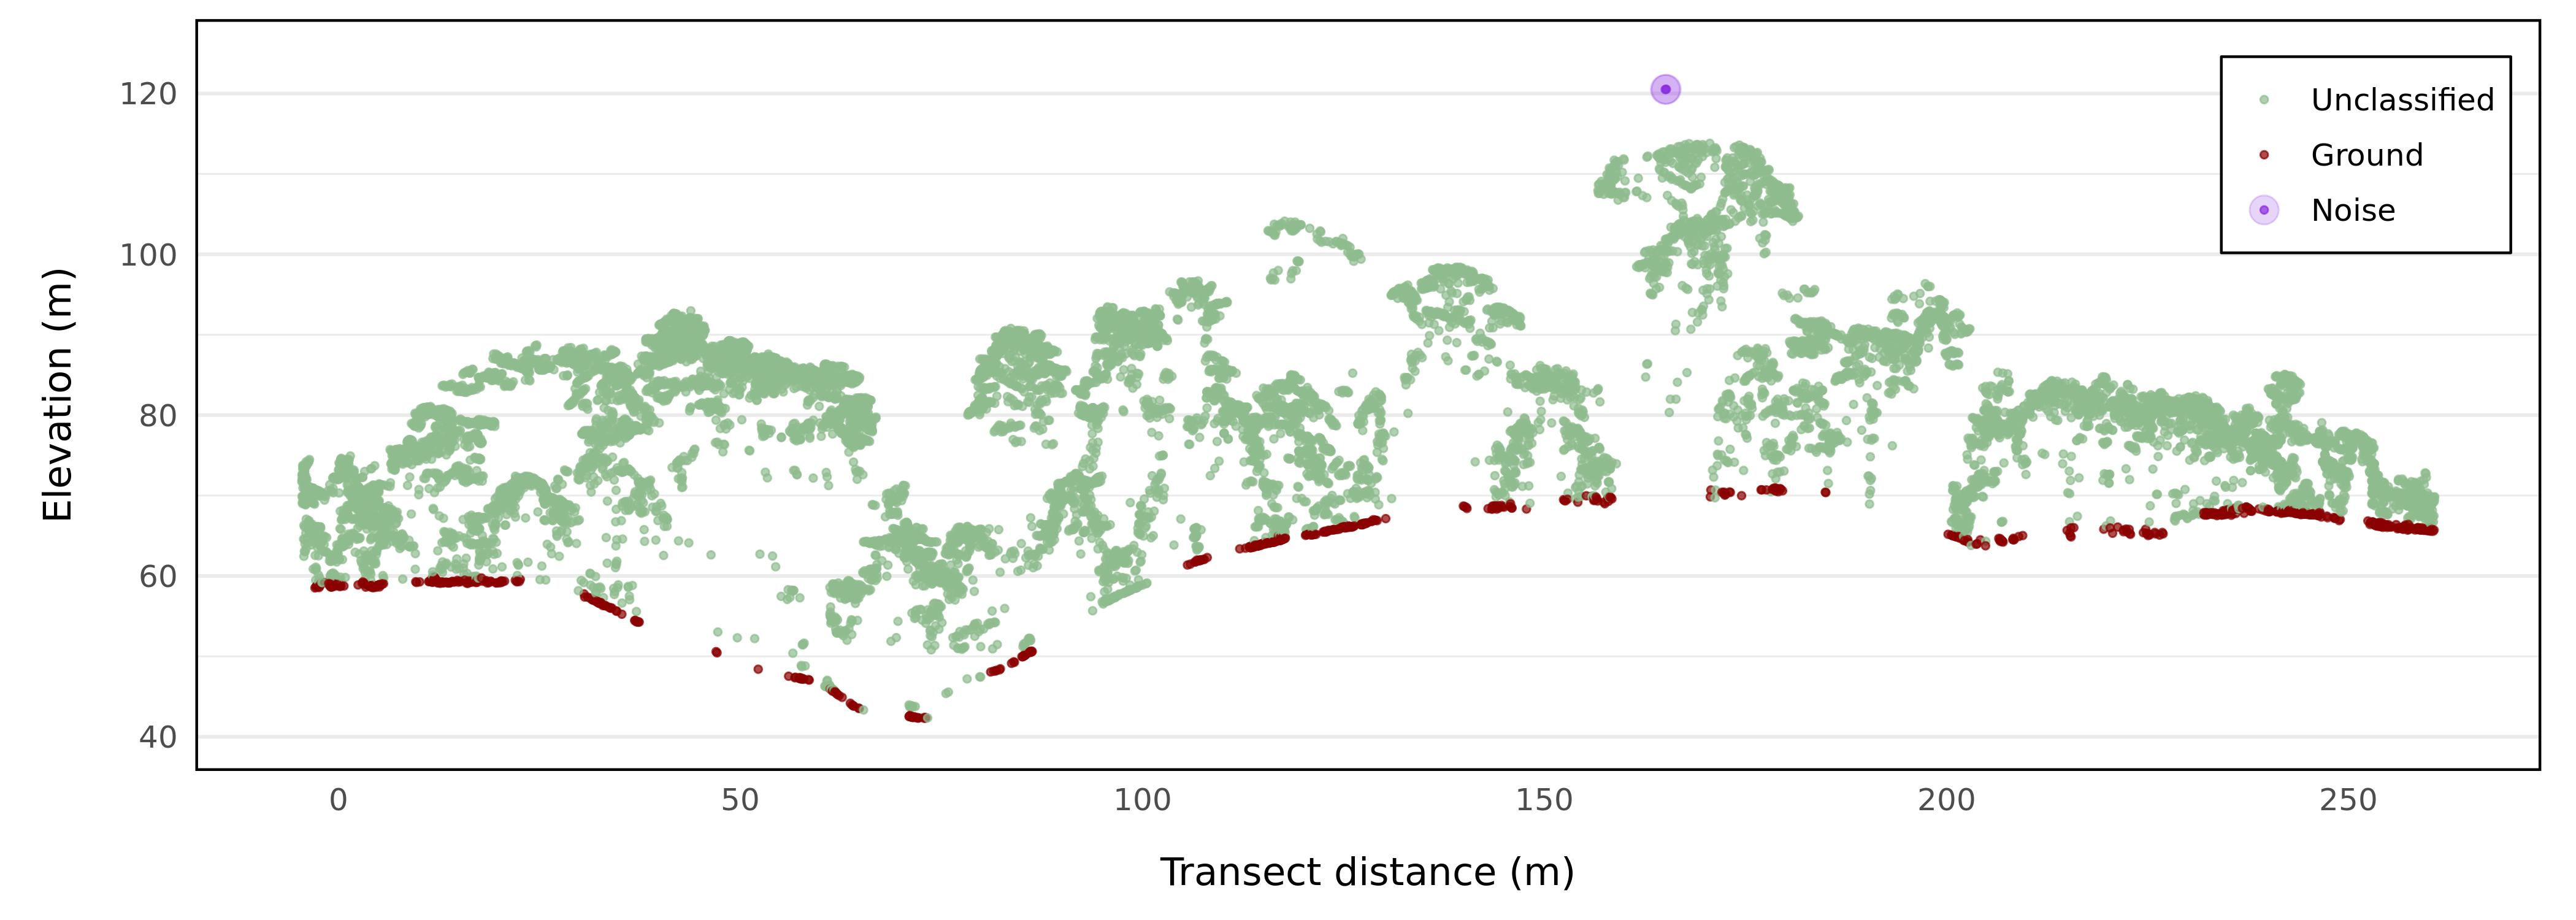

In [17]:
# identify tile that overlaps with transect

transect = data.frame(lon = c(625584, 625321),
                    lat = c(1012871, 1012906),
                   type = "transect") |>
    st_as_sf(coords = c("lon", "lat"), crs = 32617) |>
    dplyr::group_by(type) %>% 
    dplyr::summarise() %>% 
    st_cast("LINESTRING")


path_transect = (readLAScatalog(paste0(root_dir, "/output/_1_classified_points/")) |>
    catalog_intersect(transect))$filename


p1 = c(625584, 1012871) 
p2 = c(625321 , 1012905.5)
las = readLAS(path_transect)
las_tr = clip_transect(las, p1, p2, width = 2, xz = TRUE)


fig = ggplot(payload(las_tr), aes(X,Z, color = factor(Classification))) + 
  geom_point(size = 1.8, alpha = .7, shape = 20) + 
    geom_point(data = filter(payload(las_tr), Classification == 18),
               size = 5, alpha = .2) + 
  coord_equal() + 
  theme_bw(base_size = 15) +
   scale_x_continuous(expand = expansion(mult = c(.05, .05)),
                     breaks = seq(0, 250, 50)) + 
   lims(y = c(40, 125)) +
    theme_transect +
    labs(x = "Transect distance (m)", y = "Elevation (m)") +
    scale_color_manual(labels = c("0" = "Unclassified",
                                  "2" = "Ground",
                                 "18" = "Noise"),
                      values = c("darkseagreen", "red4", "blueviolet"))

ggsave(plot = fig, 
       filename = "./figures/point_clouds/cross_section_classified.jpeg", 
       device = jpeg,
       width = 14,
       height = 5,
       units = "in",
       dpi = 300,
       bg = "white")

# plot classified points
IRdisplay::display_jpeg(file = "./figures/point_clouds/cross_section_classified.jpeg") 


**A cross section of a point cloud illustrating points classified as noise with the isolated voxels filter.**

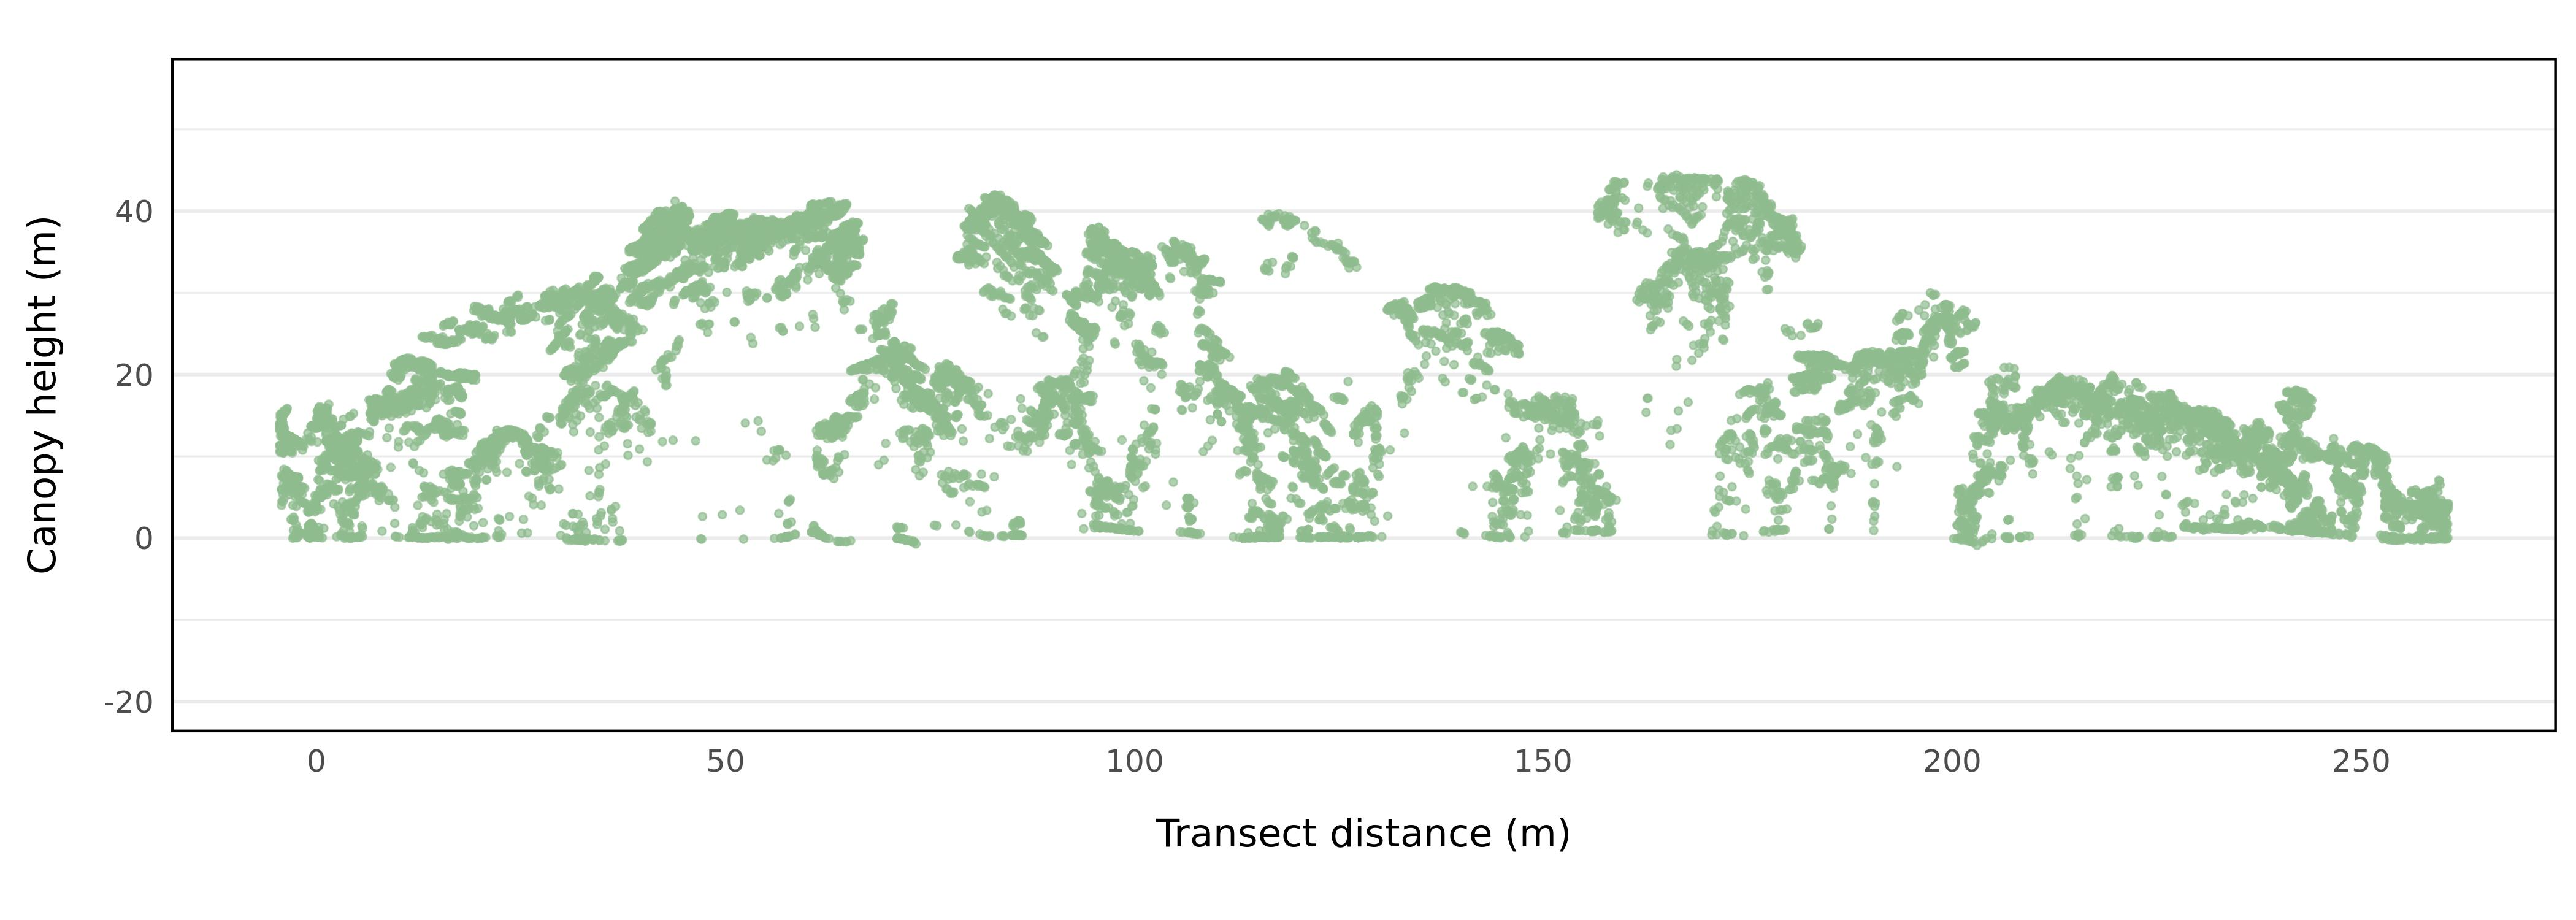

In [18]:
# plot transect canopy height
path_transect = (readLAScatalog(paste0(root_dir, "/output/_3_normalized_points/")) |>
    catalog_intersect(transect))$filename


p1 = c(625584, 1012871) 
p2 = c(625321 , 1012905.5)
las = readLAS(path_transect) #|>
    #filter_poi(Classification != "2")
las_tr = clip_transect(las, p1, p2, width = 2, xz = TRUE)


fig = ggplot(payload(las_tr), aes(X,Z)) + 
  geom_point(size = 1.8, alpha = .7, shape = 20, color = "darkseagreen") + 
  coord_equal() + 
  theme_bw(base_size = 15) +
   scale_x_continuous(expand = expansion(mult = c(.05, .05)),
                     breaks = seq(0, 250, 50)) + 
   lims(y = c(-20, 55)) +
    theme_transect +
    labs(x = "Transect distance (m)", y = "Canopy height (m)") +
    guides(legend.position = "none")

ggsave(plot = fig, 
       filename = "./figures/point_clouds/cross_section_normalized.jpeg", 
       device = jpeg,
       width = 14,
       height = 5,
       units = "in",
       dpi = 300,
       bg = "white")

# plot normalized points
IRdisplay::display_jpeg(file = "./figures/point_clouds/cross_section_normalized.jpeg") 


**A cross section of a point cloud illustrating points with Z values representing canopy height, after normalization to a digital terrain model.**

In [19]:
# define some variables for mapping in ggplot

theme_map = theme(panel.border = element_rect(color = "black", fill = NA, size = 1),
        axis.title = element_blank(),
        axis.text.x = element_text(angle = 90),
        axis.ticks = element_blank(),
        legend.position = c(.98, .02),
        legend.justification = c(1, 0),
        panel.background = element_rect(fill = "white"),
        legend.key = element_rect(fill = "white", color = "white"),
        legend.title = element_text(hjust = 0.5),
        legend.direction = "horizontal",
        legend.key.width = unit(.35, "in"),
        legend.key.height = unit(.1, "in"),
        legend.background = element_rect(color = "black", fill = "white", linewidth = .5),
        legend.margin = ggplot2::margin(4, 10, 4, 10))

cols_gradient <- c(low = "#002070", mid = "#DD6677", high = "#F1F1A1")
cols_gradient_biomass <- c(low = "#002070", mid = "#309040", high = "#D0E358")
cols_gradient_metrics <- c(low = "#201010", mid = "#605050", high = "#E9D9C2")


preds_50m = rast("./data/ALS/output/_5_metrics_raster/predictors_50m.tif")
CHM = rast("./data/ALS/output/_4_CHM_raster/CHM.tif") |> crop(preds_50m)
CHM_smooth = rast("./data/ALS/output/_4_CHM_raster/CHM_smooth.tif") |> crop(preds_50m)
DTM_smooth = rast("./data/ALS/output/_2_DTM_raster/DTM_smooth.tif") |> crop(preds_50m)

Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”
Warning message:
“A numeric `legend.position` argument in `theme()` was deprecated in ggplot2
3.5.0.
ℹ Please use the `legend.position.inside` argument of `theme()` instead.”


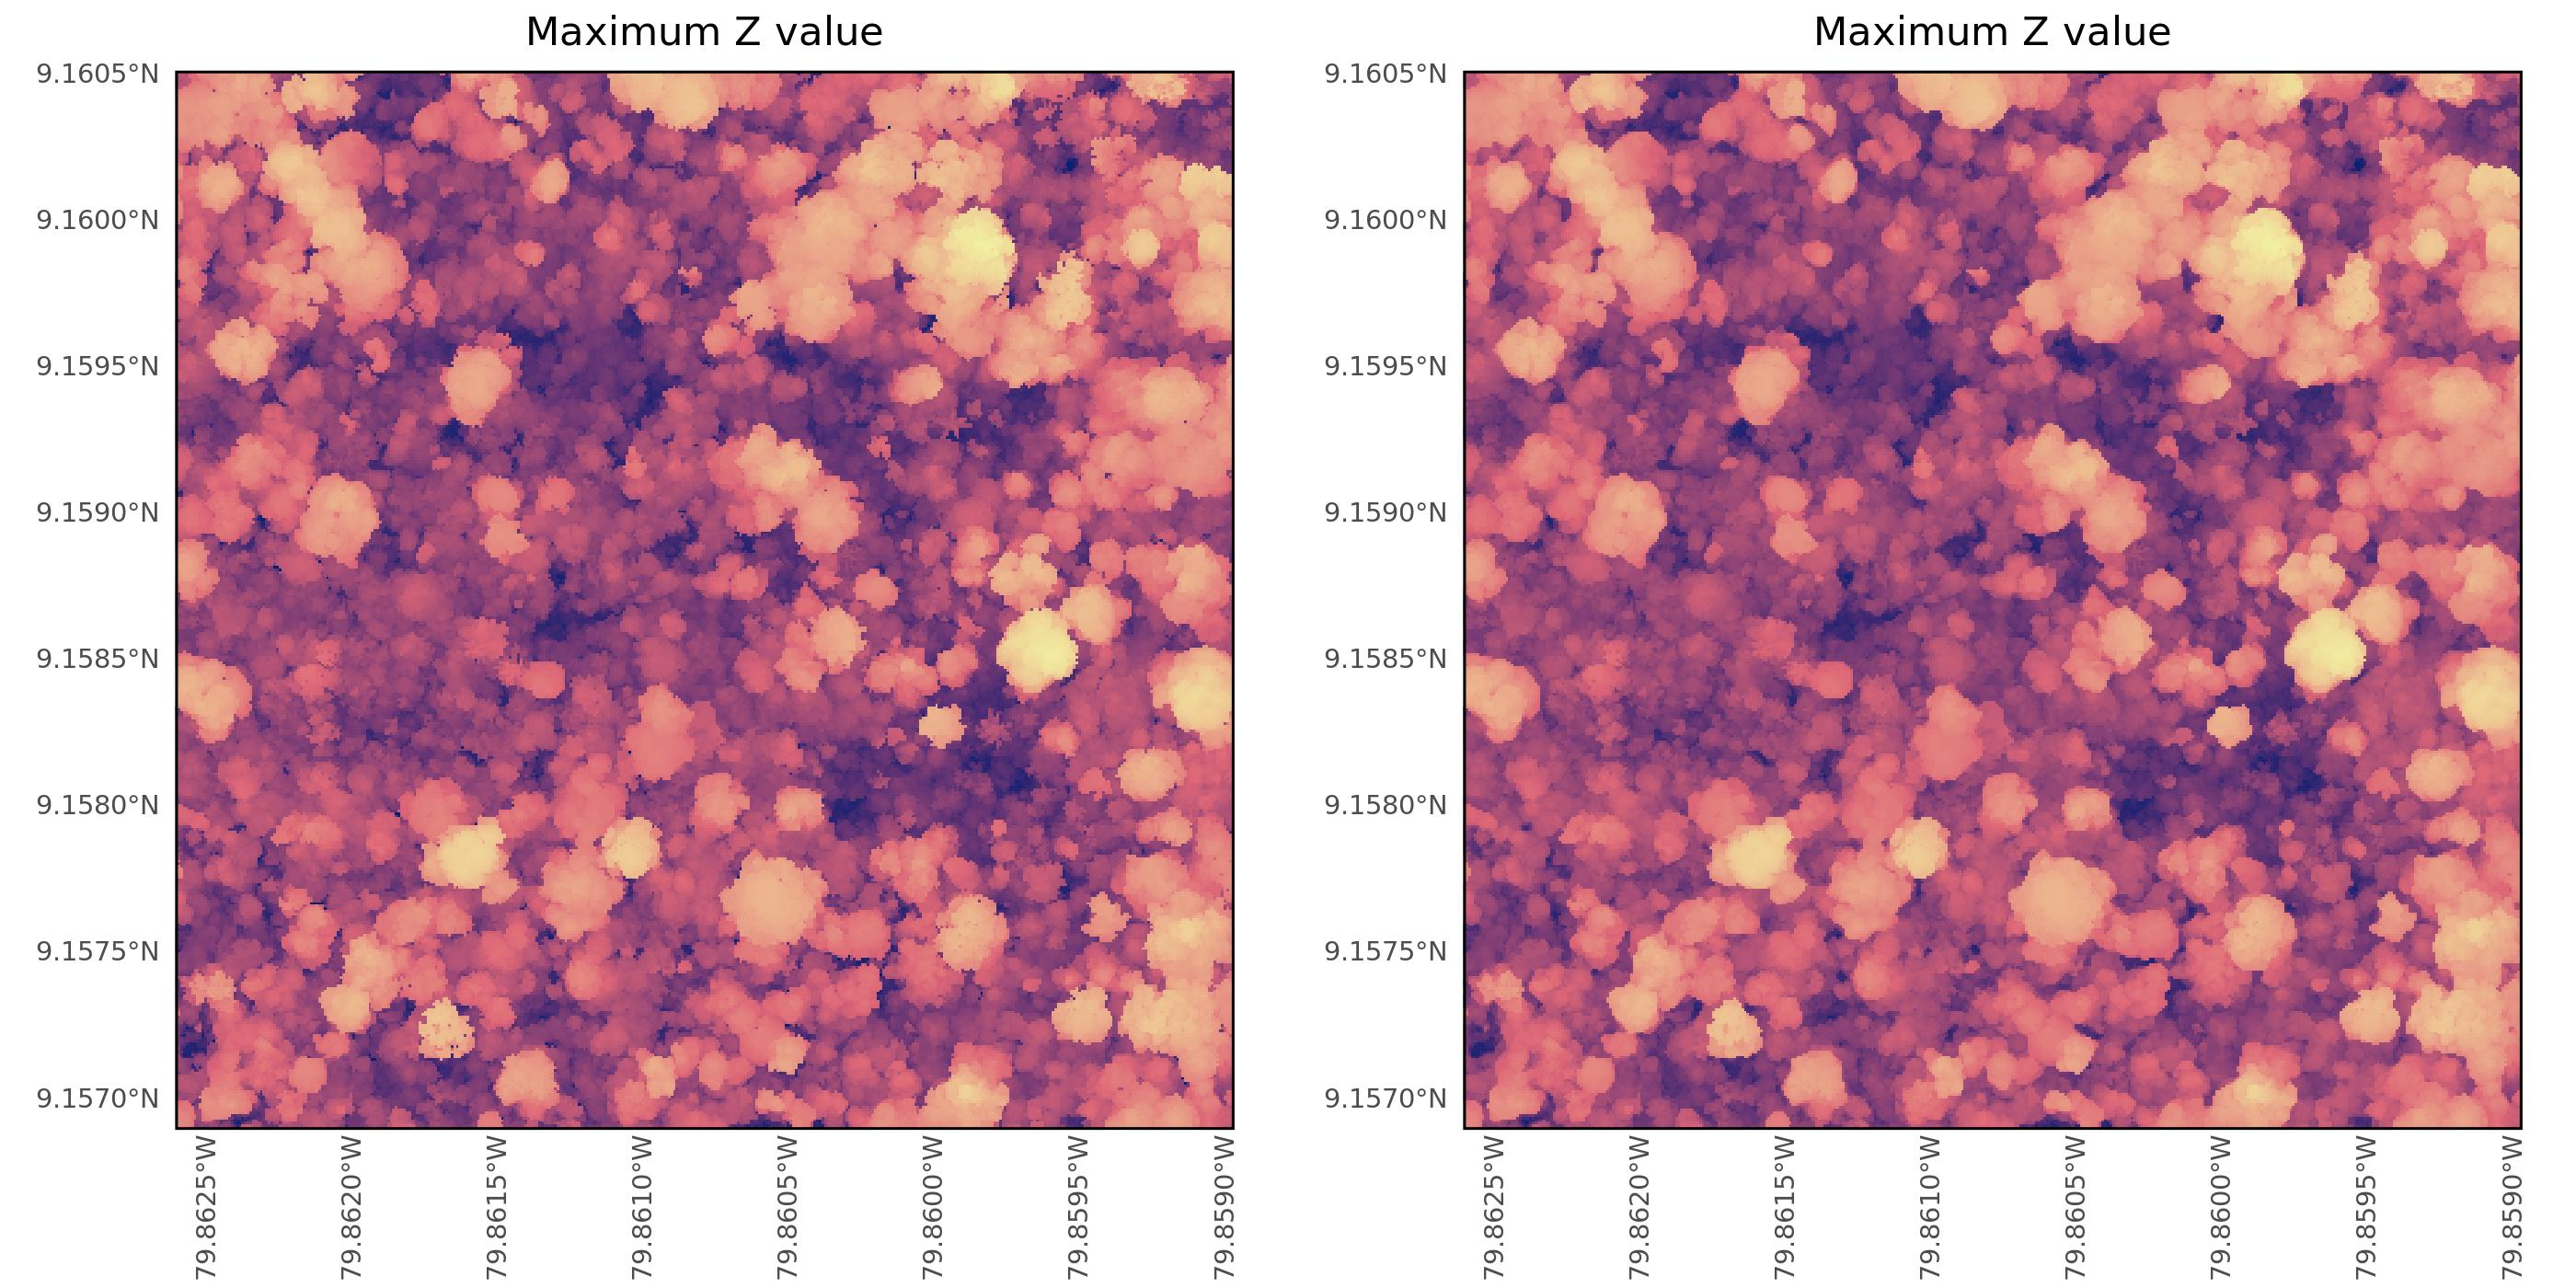

In [20]:
# plots for CHM filtering

suppressMessages({

p1 = ggplot() +
    ggR(CHM |> terra::crop(plots_buf_200m[2,]),
           geom_raster= TRUE, ggLayer = TRUE) +
    scale_fill_gradientn(colors = cols_gradient,
                         na.value = cols_gradient[[1]],
                        name = "Canopy height (m)") +
   #geom_sf(data = plots[1,], color = "red3", fill = NA, linewidth = 1) +
   scale_x_continuous(expand = expansion(mult = c(0, 0))) + 
   scale_y_continuous(expand = expansion(mult = c(0, 0))) +
    theme_bw(base_size = 13) +
   theme_map +
    coord_sf(crs = 32617) +
    guides(fill = "none") +
  ggtitle("Maximum Z value") +
  theme(plot.title = element_text(hjust = 0.5))

p2 = p1 + ggR(CHM_smooth |> terra::crop(plots_buf_200m[2,]),
           geom_raster= TRUE, ggLayer = TRUE) 

fig = ggarrange(p1, p2,
        ncol = 2, nrow = 1)

})
    
ggsave(plot = fig, 
       filename = "./figures/raster/CHM_filter.jpeg", 
       device = jpeg,
       width = 14,
       height = 7,
       units = "in",
       dpi = 200,
       bg = "white")

# plot CHM and cleaned CHM
IRdisplay::display_jpeg(file = "./figures/raster/CHM_filter.jpeg") 


**A subset of the unfiltered canopy height model (the maxmimum Z value of each cell) and the cleaned canopy height model (the result of the roughness-median filter).**

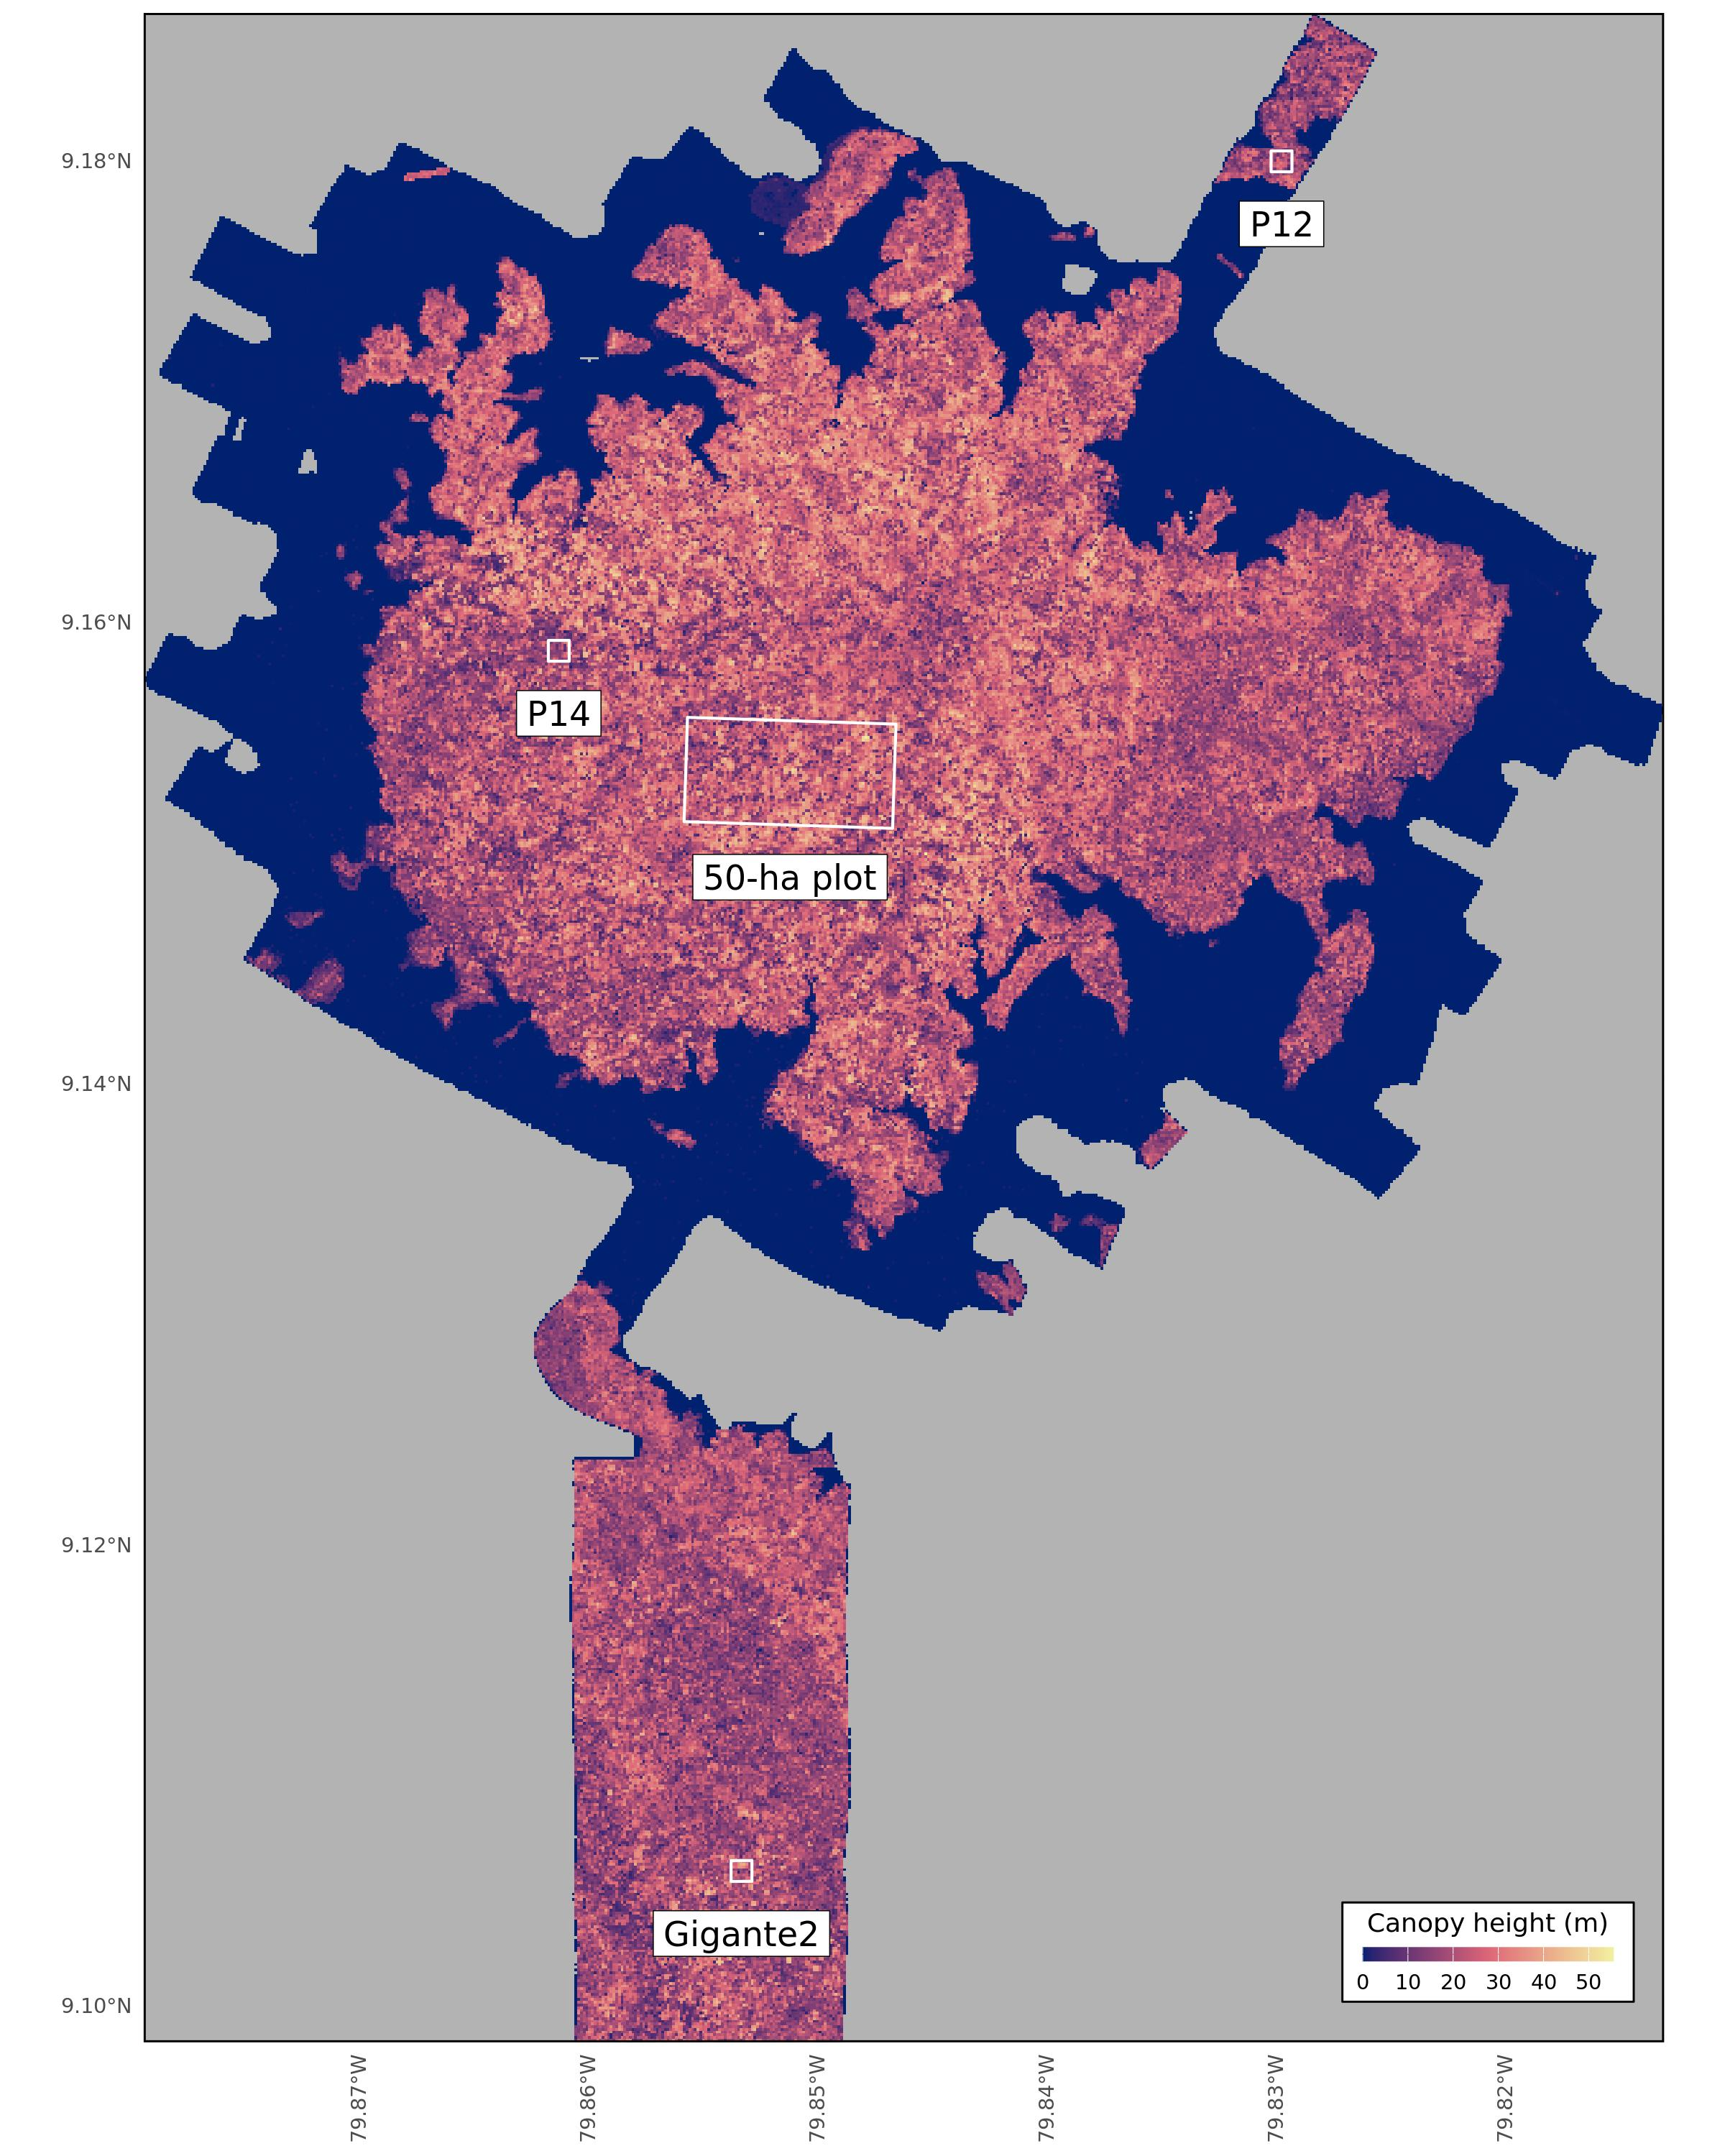

In [21]:
# plot the whole study area 

suppressMessages({

coverage_CHM <- ggR(CHM_smooth |>
                     clamp(lower = 0),
           geom_raster = TRUE) +
    scale_fill_gradientn(colors = cols_gradient,
                         na.value = "grey70",
                        # limits = c(range_CHM),
                        name = "Canopy height (m)") +
   geom_sf(data = plots, color = "white", fill = NA, linewidth = .7) +
     geom_sf_label(data = plots |> filter(NAME != "50-ha plot"), 
                   aes(label = NAME),
                   nudge_y = -300,
                    size = 6, 
            label.r = unit(0, "pt")) +
      geom_sf_label(data = plots |> filter(NAME == "50-ha plot"), 
                   aes(label = NAME),
                   nudge_y = -500,
                    size = 6, 
            label.r = unit(0, "pt")) +
   scale_x_continuous(expand = expansion(mult = c(0, 0))) + 
   scale_y_continuous(expand = expansion(mult = c(-.16, 0))) +
     theme_bw(base_size = 13) +
   theme_map +
    #coord_sf(crs = 32617) +
    guides(fill = guide_colourbar(title.position="top"))

})
    
ggsave(plot = coverage_CHM, 
       filename = "./figures/raster/CHM_BCI_Gigante.jpeg", 
       device = jpeg,
       width = 12,
       height = 15,
       units = "in",
       dpi = 200,
       bg = "white")

IRdisplay::display_jpeg(file = "./figures/raster/CHM_BCI_Gigante.jpeg") 


**The full canopy height model (CHM) for the airborne laser scanning (ALS) acquisition, with field plot boundaries outlined in white. The study area covers all of Barro Colorado Island in the center, a portion of the Buena Vista Peninsula to the north, and a portion of the Gigante Peninsula to the south.**

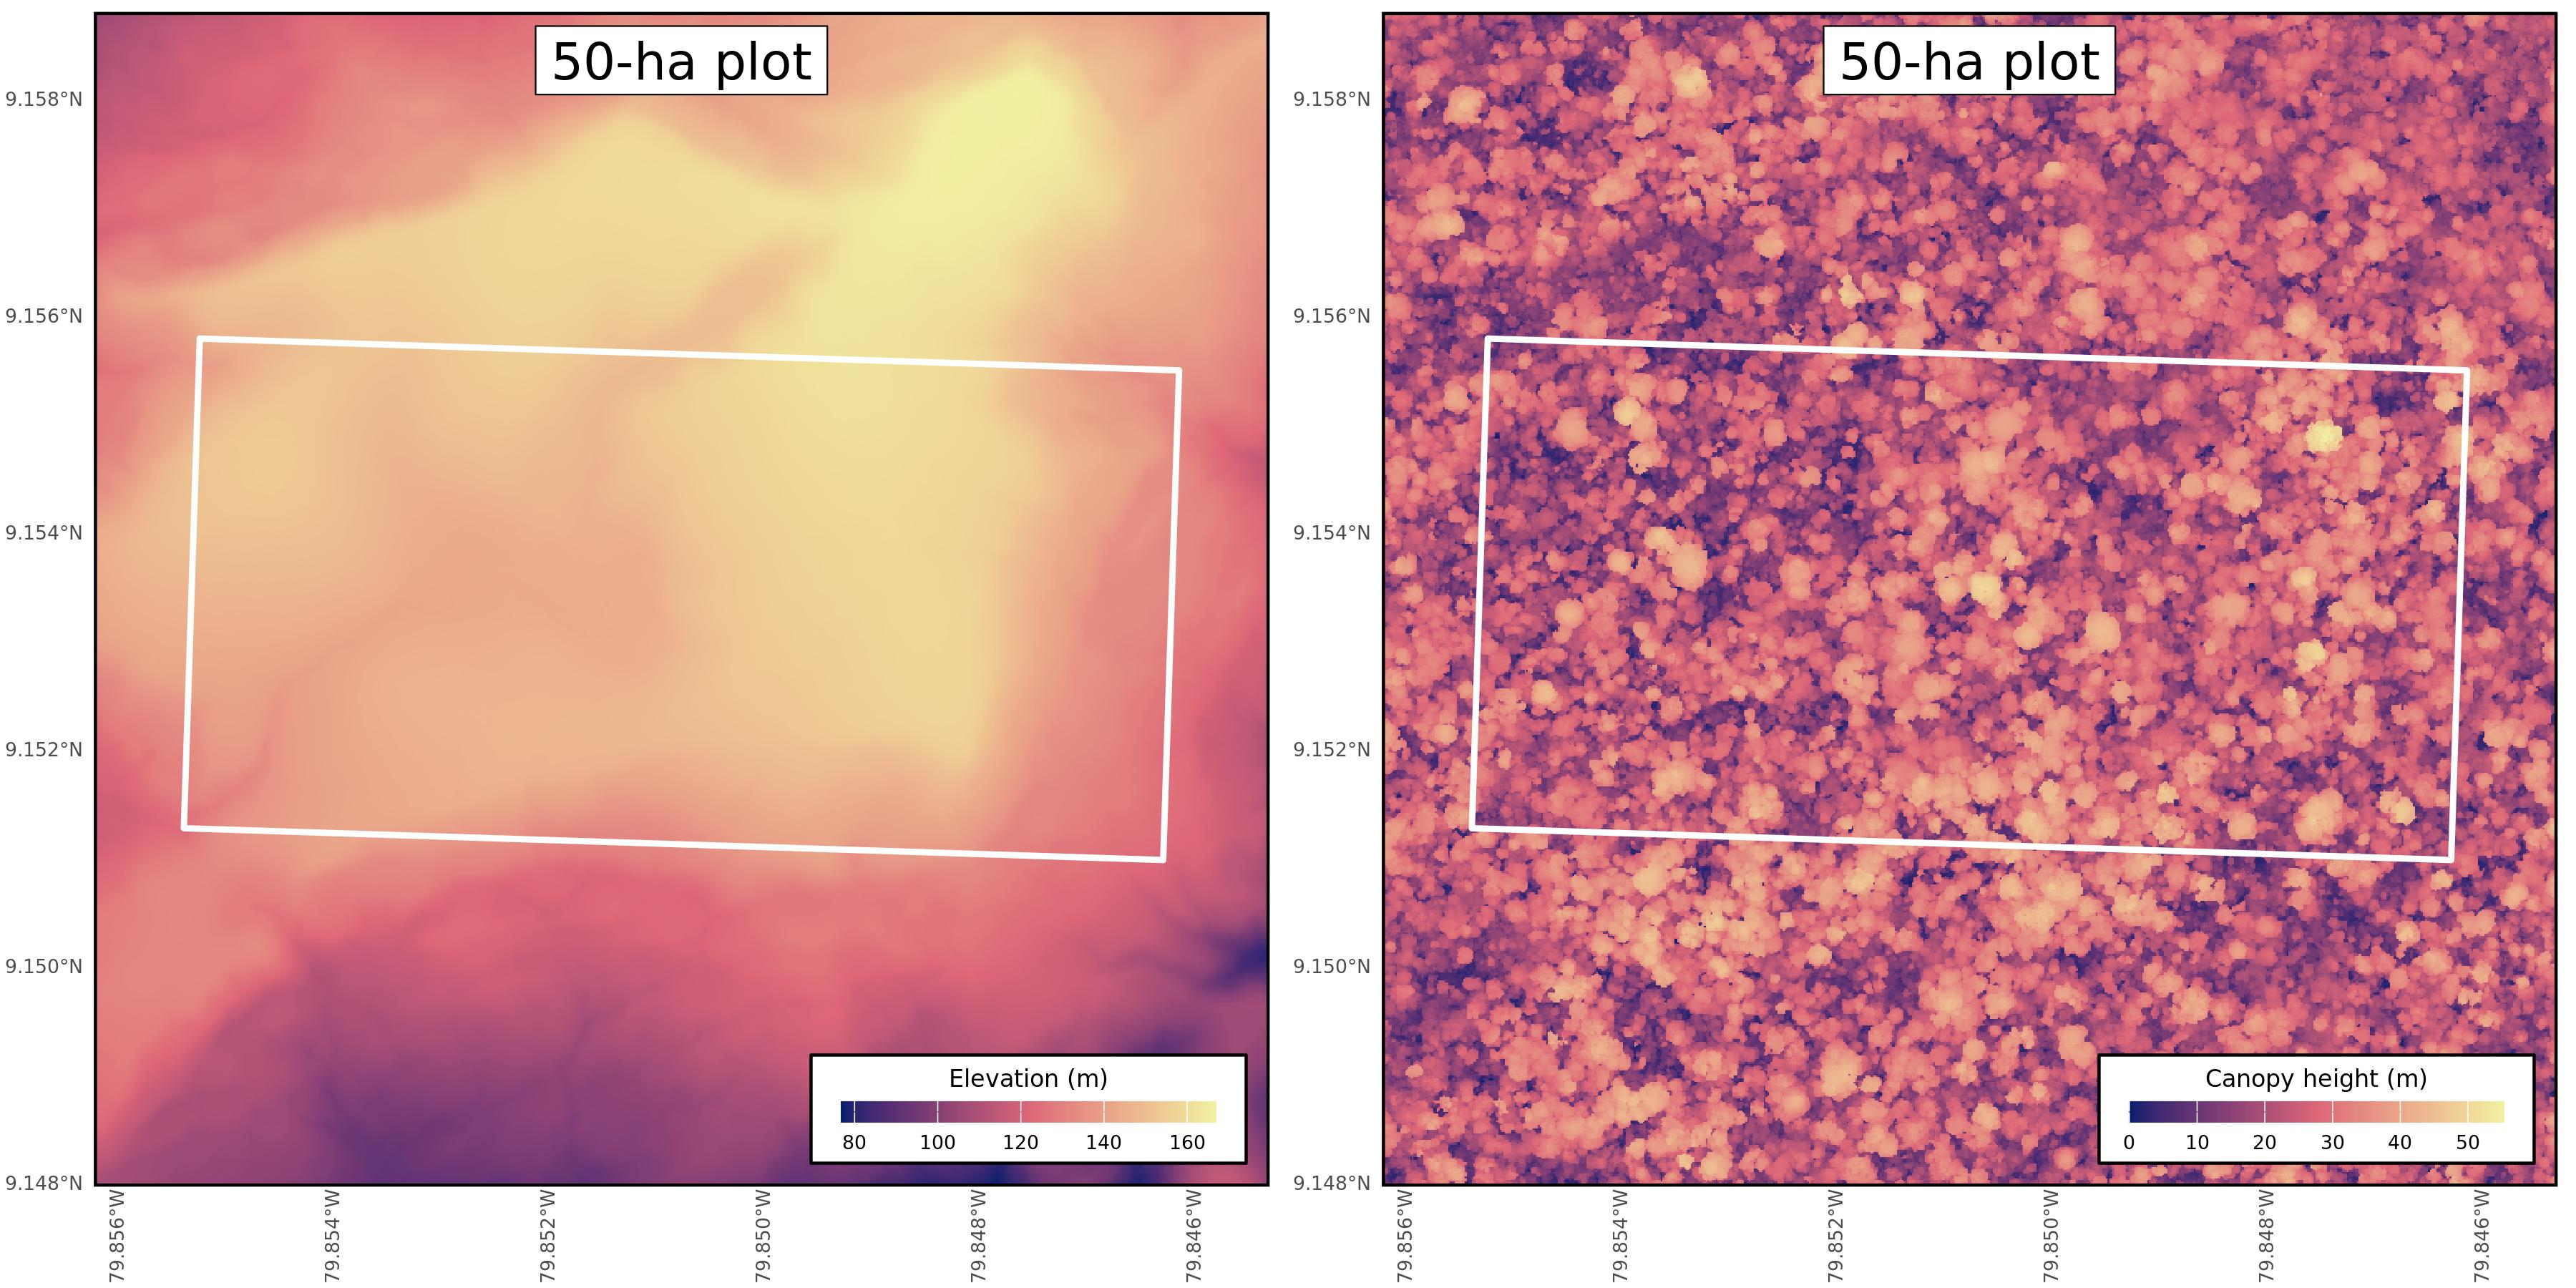

In [22]:
# plot the DTM and CHM for the 50-ha plot

range_DTM <- DTM_smooth |> terra::mask(plots) |> minmax()
range_CHM <- CHM_smooth |> terra::mask(plots) |> minmax()

suppressMessages({
    
p1 = ggR(DTM_smooth |> terra::crop(st_buffer(plots_buf_200m[1,], 400)),
               geom_raster = TRUE) +
            scale_fill_gradientn(colors = cols_gradient,
                                na.value = "grey70",
                                # limits = c(range_DTM),
                                name = "Elevation (m)") +
           geom_sf(data = plots[1,], color = "white", fill = NA, linewidth = 1) +
                 geom_sf_label(data = plots[1,],
                            aes(label = NAME),
                            vjust = 1,
                            nudge_y = 585,
                            size = 6, 
                    label.r = unit(0, "pt")) +
            scale_x_continuous(expand = expansion(mult = c(0, 0))) + 
           scale_y_continuous(expand = expansion(mult = c(0, 0))) +
            theme_bw(base_size = 8) +
           theme_map +
            guides(fill = guide_colourbar(title.position="top"))

p2 = ggR(CHM_smooth |> terra::crop(st_buffer(plots_buf_200m[1,], 400)),
               geom_raster = TRUE) +
            scale_fill_gradientn(colors = cols_gradient,
                                na.value = "grey20",
                                limits = c(range_CHM),
                                name = "Canopy height (m)") +
           geom_sf(data = plots[1,], color = "white", fill = NA, linewidth = 1) +
                 geom_sf_label(data = plots[1,],
                            aes(label = NAME),
                            vjust = 1,
                            nudge_y = 585,
                            size = 6, 
                    label.r = unit(0, "pt")) +
            scale_x_continuous(expand = expansion(mult = c(0, 0))) + 
           scale_y_continuous(expand = expansion(mult = c(0, 0))) +
            theme_bw(base_size = 8) +
           theme_map +
            guides(fill = guide_colourbar(title.position="top"))

fig = ggarrange(p1, p2,
        ncol = 2, nrow = 1)

})
    
ggsave(plot = fig, 
       filename = "./figures/raster/DTM_CHM_50ha.jpeg", 
       device = jpeg,
       width = 12,
       height = 6,
       units = "in",
       dpi = 300,
       bg = "white")

IRdisplay::display_jpeg(file = "./figures/raster/DTM_CHM_50ha.jpeg") 


**A subset of the canopy height model (CHM) and the 50-ha field plot of Barro Colorado Island, outline shown in white.**

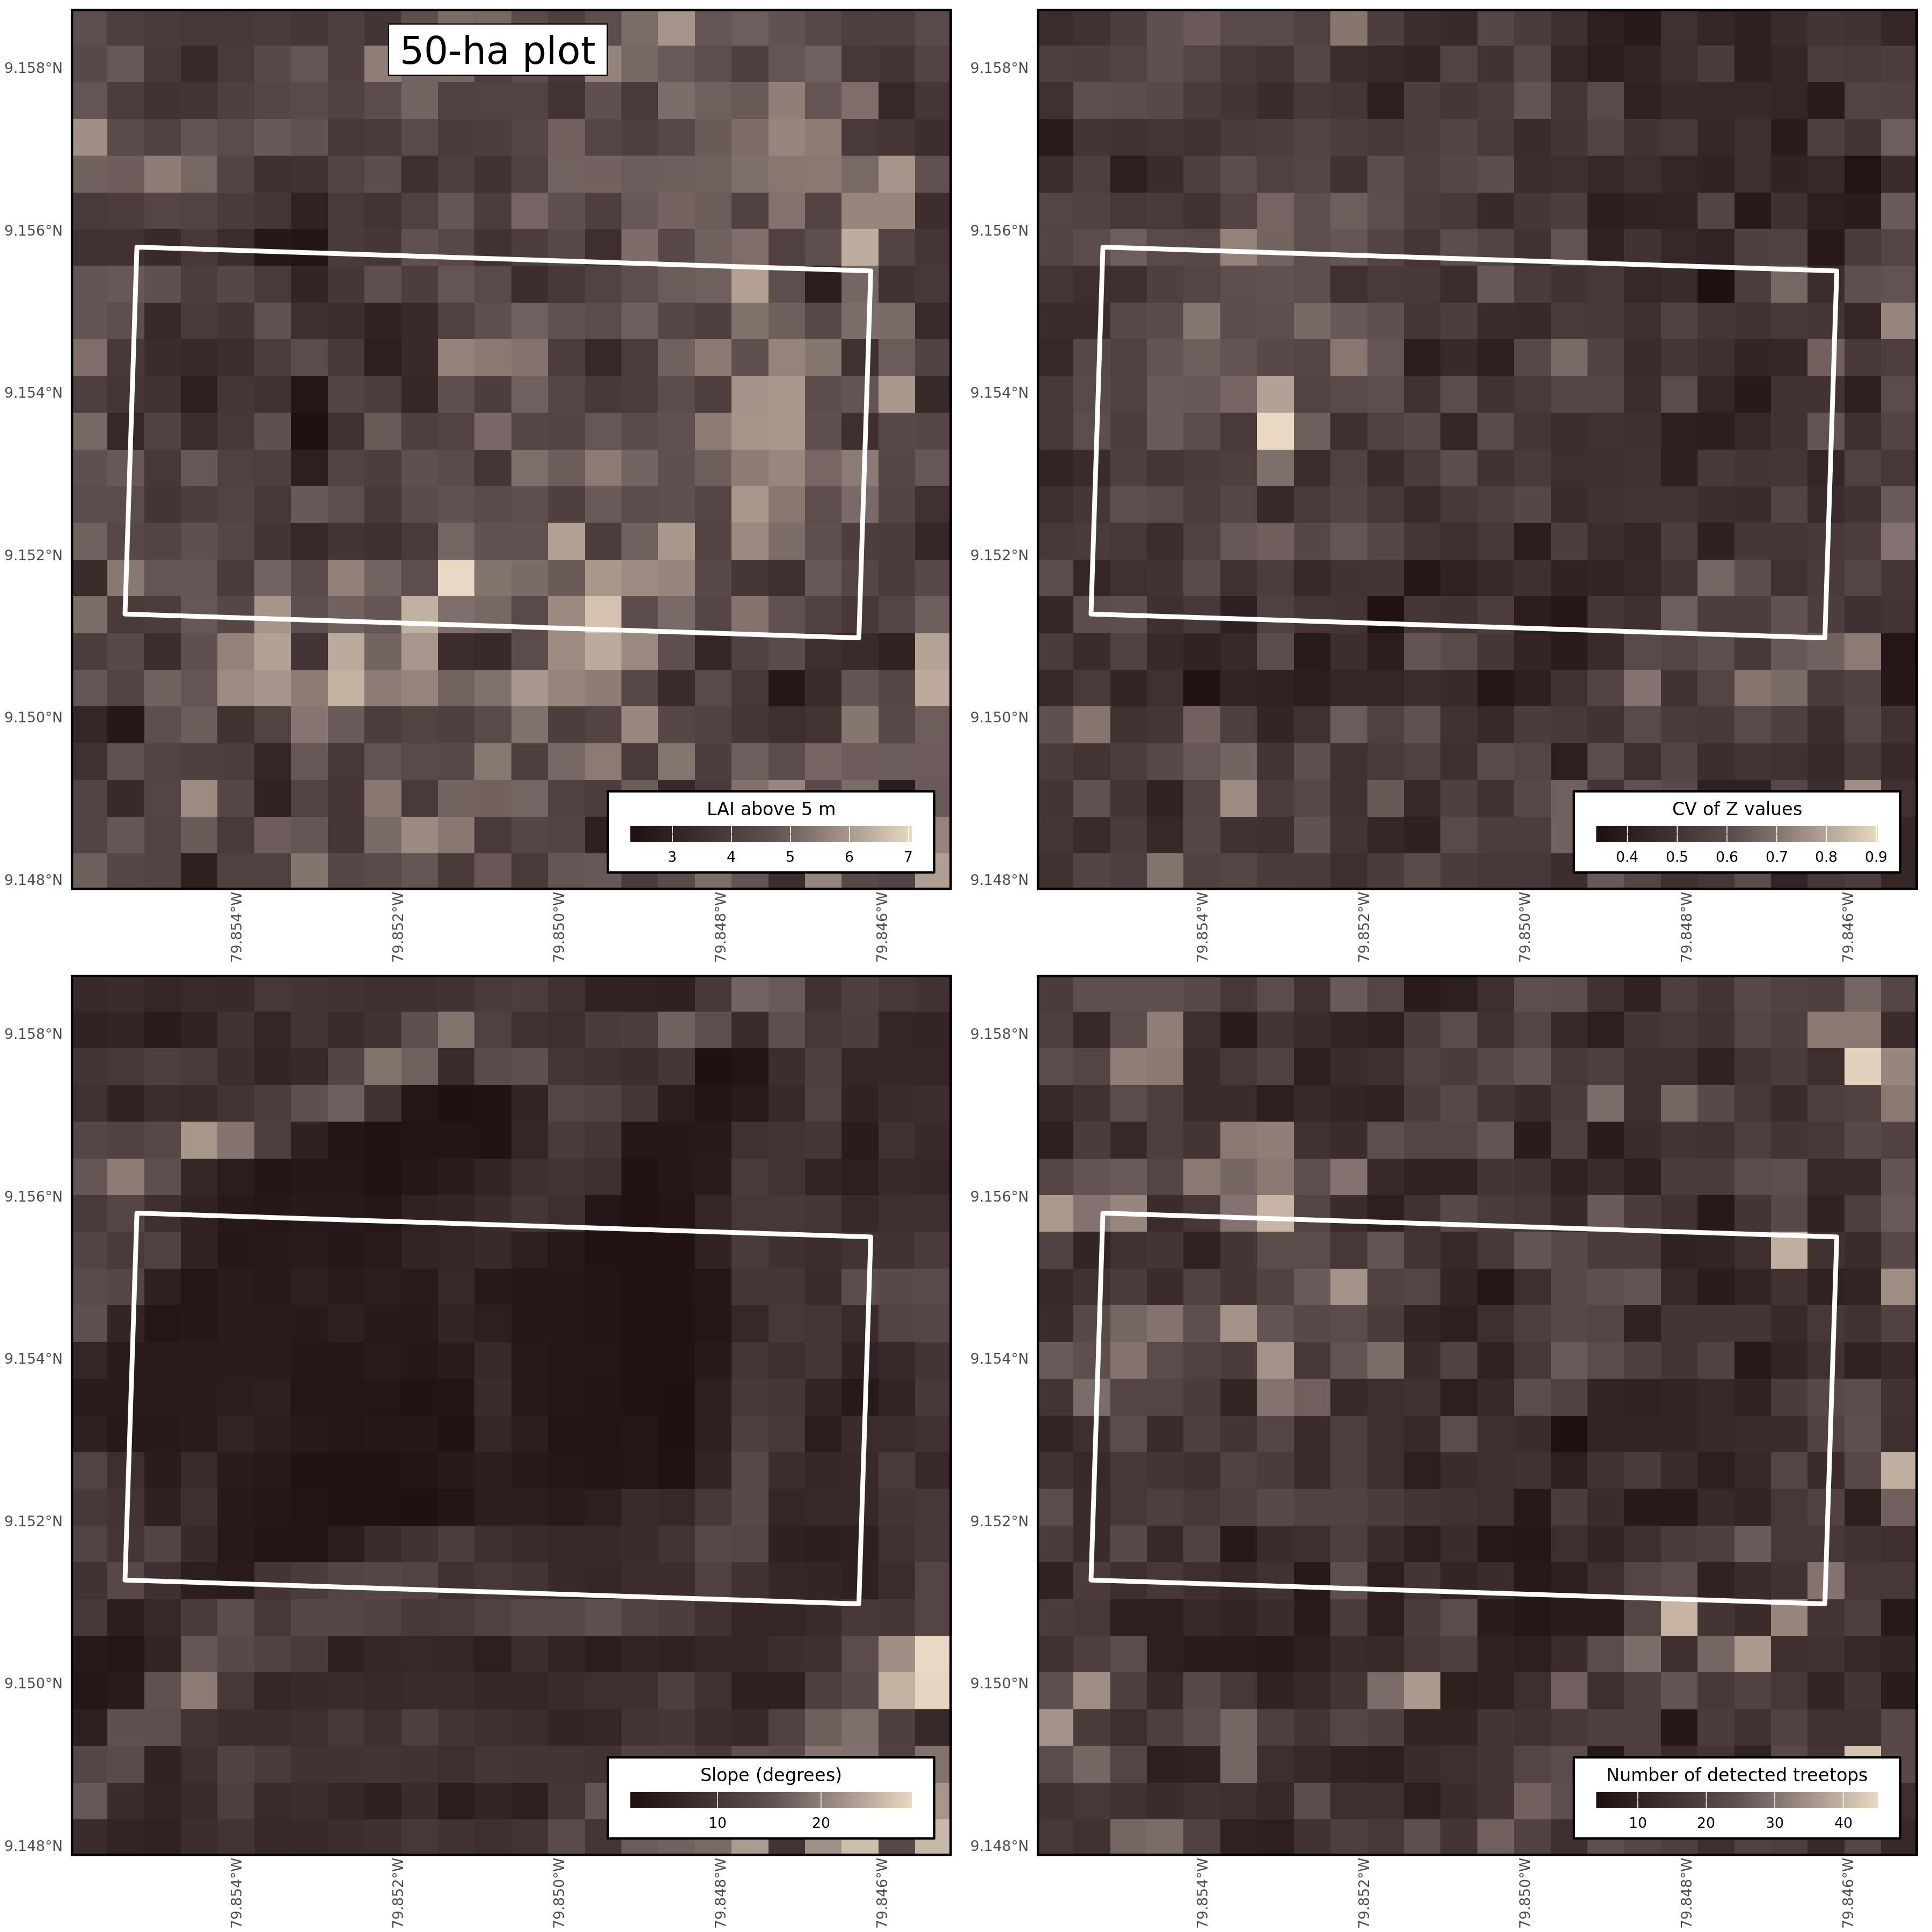

In [23]:
# plot the DTM and CHM for the 50-ha plot

predictors = rast(paste0(root_dir, "/output/_5_metrics_raster/predictors_50m.tif"))

suppressMessages({
    
p1 = ggR(predictors$LAI_5m |> terra::crop(st_buffer(plots_buf_200m[1,], 400)),
               geom_raster = TRUE) +
            scale_fill_gradientn(colors = cols_gradient_metrics,
                                na.value = "grey70",
                                # limits = c(range_DTM),
                                name = "LAI above 5 m") +
           geom_sf(data = plots[1,], color = "white", fill = NA, linewidth = 1) +
                 geom_sf_label(data = plots[1,],
                            aes(label = NAME),
                            vjust = 1,
                            nudge_y = 570,
                            size = 6, 
                    label.r = unit(0, "pt")) +
            scale_x_continuous(expand = expansion(mult = c(0, 0))) + 
           scale_y_continuous(expand = expansion(mult = c(0, 0))) +
            theme_bw(base_size = 8) +
           theme_map +
            guides(fill = guide_colourbar(title.position="top"))

p2 = ggR(predictors$Z_CV |> terra::crop(st_buffer(plots_buf_200m[1,], 400)),
               geom_raster = TRUE) +
            scale_fill_gradientn(colors = cols_gradient_metrics,
                                na.value = "grey70",
                                #limits = c(range_CHM),
                                name = "CV of Z values") +
           geom_sf(data = plots[1,], color = "white", fill = NA, linewidth = 1) +
            scale_x_continuous(expand = expansion(mult = c(0, 0))) + 
           scale_y_continuous(expand = expansion(mult = c(0, 0))) +
            theme_bw(base_size = 8) +
           theme_map +
            guides(fill = guide_colourbar(title.position="top"))

p3 = ggR(predictors$Slope |> terra::crop(st_buffer(plots_buf_200m[1,], 400)),
               geom_raster = TRUE) +
            scale_fill_gradientn(colors = cols_gradient_metrics,
                                na.value = "grey70",
                                # limits = c(range_DTM),
                                name = "Slope (degrees)") +
           geom_sf(data = plots[1,], color = "white", fill = NA, linewidth = 1) +
            scale_x_continuous(expand = expansion(mult = c(0, 0))) + 
           scale_y_continuous(expand = expansion(mult = c(0, 0))) +
            theme_bw(base_size = 8) +
           theme_map +
            guides(fill = guide_colourbar(title.position="top"))

p4 = ggR(predictors$Treetops |> terra::crop(st_buffer(plots_buf_200m[1,], 400)),
               geom_raster = TRUE) +
            scale_fill_gradientn(colors = cols_gradient_metrics,
                                na.value = "grey70",
                                #limits = c(range_CHM),
                                name = "Number of detected treetops") +
           geom_sf(data = plots[1,], color = "white", fill = NA, linewidth = 1) +
            scale_x_continuous(expand = expansion(mult = c(0, 0))) + 
           scale_y_continuous(expand = expansion(mult = c(0, 0))) +
            theme_bw(base_size = 8) +
           theme_map +
            guides(fill = guide_colourbar(title.position="top"))

fig = ggarrange(p1, p2, p3, p4,
        ncol = 2, nrow = 2)

})
    
ggsave(plot = fig, 
       filename = "./figures/raster/predictors_50ha.jpeg", 
       device = jpeg,
       width = 12,
       height = 12,
       units = "in",
       dpi = 300,
       bg = "white")

IRdisplay::display_jpeg(file = "./figures/raster/predictors_50ha.jpeg") 

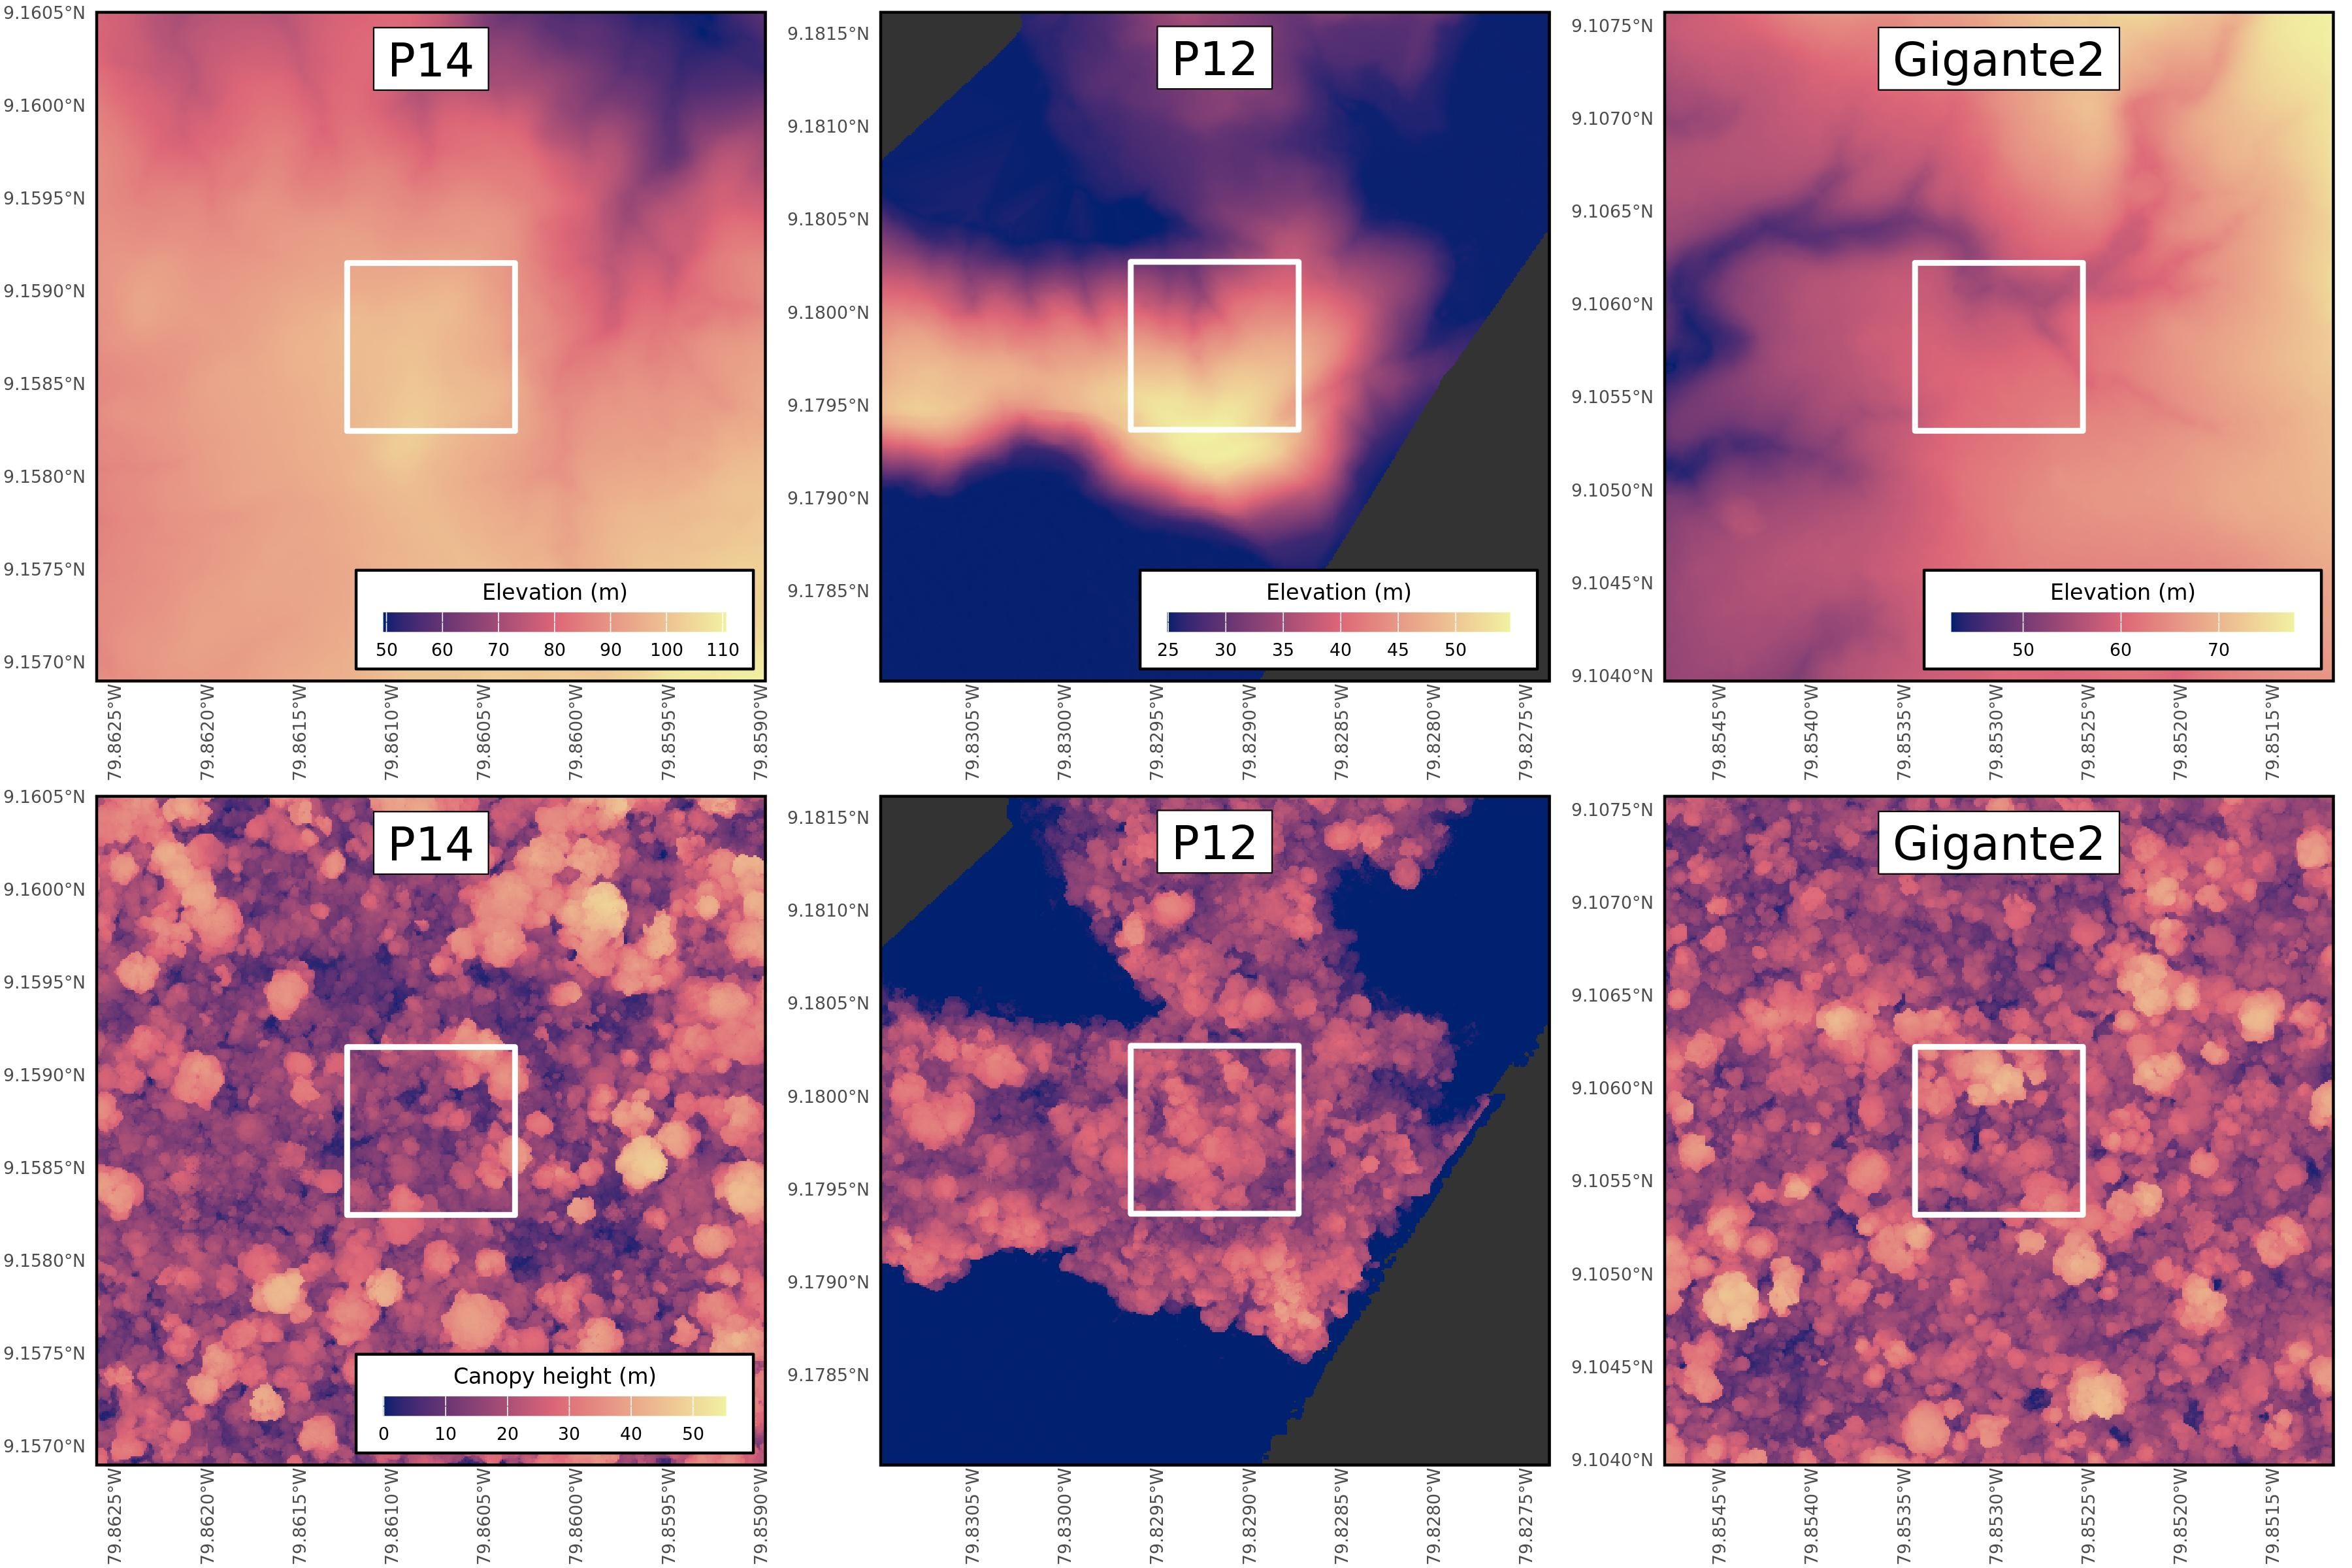

In [24]:
# plot the DTM and CHM for the smaller plots

DTM_list = list()
CHM_list = list()

for (i in 2:4) {

    suppressMessages({
        
     DTM_list[[i]] = ggR(DTM_smooth |> terra::crop(plots_buf_200m[i,]),
               geom_raster = TRUE) +
            scale_fill_gradientn(colors = cols_gradient,
                                na.value = "grey20",
                                # limits = c(range_DTM),
                                name = "Elevation (m)") +
           geom_sf(data = plots[i,], color = "white", fill = NA, linewidth = 1) +
                 geom_sf_label(data = plots_buf_200m[i,],
                            aes(label = NAME),
                            vjust = 1,
                            nudge_y = 185,
                            size = 6, 
                    label.r = unit(0, "pt")) +
            scale_x_continuous(expand = expansion(mult = c(0, 0))) + 
           scale_y_continuous(expand = expansion(mult = c(0, 0))) +
            theme_bw(base_size = 8) +
           theme_map +
            guides(fill = guide_colourbar(title.position="top"))

        CHM_list[[i]] = ggR(CHM_smooth |> terra::crop(plots_buf_200m[i,]),
               geom_raster = TRUE) +
            scale_fill_gradientn(colors = cols_gradient,
                                na.value = "grey20",
                                limits = c(range_CHM),
                                name = "Canopy height (m)") +
           geom_sf(data = plots[i,], color = "white", fill = NA, linewidth = 1) +
                 geom_sf_label(data = plots_buf_200m[i,],
                            aes(label = NAME),
                            vjust = 1,
                            nudge_y = 185,
                            size = 6, 
                    label.r = unit(0, "pt")) +
            scale_x_continuous(expand = expansion(mult = c(0, 0))) + 
           scale_y_continuous(expand = expansion(mult = c(0, 0))) +
            theme_bw(base_size = 8) +
           theme_map +
            guides(fill = guide_colourbar(title.position="top"))
        })
    
}


fig = ggarrange(DTM_list[[2]], 
                DTM_list[[3]],
                DTM_list[[4]],
                CHM_list[[2]],
                CHM_list[[3]] + guides(fill = "none"), 
                CHM_list[[4]] + guides(fill = "none"),
        ncol = 3, nrow = 2)

#})
    
ggsave(plot = fig, 
       filename = "./figures/raster/plots_DTM_CHM.jpeg", 
       device = jpeg,
       width = 12,
       height = 8,
       units = "in",
       dpi = 300,
       bg = "white")

IRdisplay::display_jpeg(file = "./figures/raster/plots_DTM_CHM.jpeg") 


**400-by-400m subets of digital terrain models (DTM) and canopy height models (CHM) for the locations of the field plots. The 1-ha plot boundaries are shown in white.**


### **7.** Quantify aboveground biomass from field data.


In [25]:

preds_50m = rast("./data/ALS/output/_5_metrics_raster/predictors_50m.tif")
CHM = rast("./data/ALS/output/_4_CHM_raster/CHM.tif") |> crop(preds_50m)
CHM_smooth = rast("./data/ALS/output/_4_CHM_raster/CHM_smooth.tif") |> crop(preds_50m)
DTM_smooth = rast("./data/ALS/output/_2_DTM_raster/DTM_smooth.tif") |> crop(preds_50m)

bci_50ha_plot <- st_read('/projects/shared-buckets/samuel.grubinger/GIS/BCI_50ha.shp') |>
    mutate(NAME = "50-ha plot",
           AREA_HA = AREA,
           ORIGIN_X = 625773.86,
           ORIGIN_Y = 1011775.84) |>
    dplyr::select(NAME, AREA_HA, ORIGIN_X, ORIGIN_Y, geometry)

small_plots = st_read('/projects/shared-buckets/samuel.grubinger/GIS/CTFS_Plots_Polygons.shp') |>
    mutate(NAME = DESC_,
          ORIGIN_X = Origin_X,
          ORIGIN_Y = Origin_Y) |>
    dplyr::select(NAME, AREA_HA, ORIGIN_X, ORIGIN_Y, geometry) |>
        mutate(ORIGIN_X = if_else(NAME == "Gigante2", 625999 - 300, ORIGIN_X), # for gigante2 only, check other plots
               ORIGIN_Y = if_else(NAME == "Gigante2", 1006695 - 700, ORIGIN_Y)) |>
    st_set_crs(32617)


get_orientation_in_radians = function(x) {

        coords = x |>
            st_coordinates() |>
            as_tibble() |>
            distinct(X, Y) |>
            arrange(Y) |>
            slice_head(n = 2) |>
            arrange(X)
        
        theta = atan((coords[[2,2]] - coords[[1,2]]) / (coords[[2,1]] - coords[[1,1]])) 

    }


plots <- bind_rows(bci_50ha_plot, small_plots) |>
    filter(NAME %in% c("50-ha plot", "P12", "P14", "Gigante2")) |>
    group_by(NAME) |>
    mutate(THETA = get_orientation_in_radians(geometry))

plots_buf_200m = plots |>
    st_centroid() |>
    st_buffer(200)

Reading layer `BCI_50ha' from data source 
  `/projects/shared-buckets/samuel.grubinger/GIS/BCI_50ha.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 1 feature and 5 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 625773.9 ymin: 1011743 xmax: 626789.6 ymax: 1012276
Projected CRS: WGS 84 / UTM zone 17N
Reading layer `CTFS_Plots_Polygons' from data source 
  `/projects/shared-buckets/samuel.grubinger/GIS/CTFS_Plots_Polygons.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 60 features and 7 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 611661.9 ymin: 988811 xmax: 660217.9 ymax: 1032197
Projected CRS: WGS 84 / UTM zone 17N


Warning message:
“st_centroid assumes attributes are constant over geometries”


In [26]:
# load in the Panama plot data from 2023
census = read.csv('./data/Field/request_2023.csv')
#load('./data/Field/bci.stem9.Rdata')
#census = bci.stem9
                 

census_live = census |>
    mutate(NAME = case_match(PlotName,  
                      "bci" ~ "50-ha plot",
                      "gigante2" ~ "Gigante2",
                            .default = PlotName)) |>
    filter(Status != "dead"
           & NAME %in% c("50-ha plot", "P12", "P14", "Gigante2") 
           & PY > 0
           & !(is.na(PX)) & !(is.na(PY))) |>
    left_join(st_drop_geometry(plots)) |>
    mutate(DBH = as.numeric(DBH),
           X = as.numeric(PX),
           Y = as.numeric(PY),
           X_UTM = ORIGIN_X + sqrt(X^2 + Y^2) * cos (atan(Y/X) + THETA),
           Y_UTM = ORIGIN_Y + sqrt(X^2 + Y^2) * sin (atan(Y/X) + THETA))|>
    st_as_sf(coords = c("X_UTM", "Y_UTM"), crs = 32617)

# get the average coordinates for the whole site to estimate AGB from DBH
COORD = census_live |>
    st_transform(4326) |>
    st_coordinates() |> 
    as_tibble() |>
    summarize_all(mean)

# use Chave's equations to estimate AGB for each tree of each taxon
census_agb = census_live |> 
    mutate(Density = (getWoodDensity(genus = Genus,
                            SpeciesName,
                            family = Family,
                            region = "SouthAmericaTrop"))$meanWD,
           # biomass in Mg
          AGB = computeAGB(D = DBH/10,
                           WD = Density,
                           H = NULL, 
                           coord = COORD, Dlim = NULL))

Joining with `by = join_by(NAME)`
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `DBH = as.numeric(DBH)`.
Caused by warning:
! NAs introduced by coercion”
The reference dataset contains 4191 wood density values

Your taxonomic table contains 323 taxa



In [27]:
RES = res(preds_50m)

agb = terra::rasterize(x = vect(census_agb),
                y = preds_50m, 
                field = "AGB", 
                fun = "sum",
                na.rm = TRUE,
                touches = TRUE, 
                cover = TRUE)

# get the area of each cell that intersects with the plot
# multiply by the resolution to get m^2 of plot covered by each pixel
agb_cover = terra::rasterize(x = vect(plots),
                y = preds_50m, 
                field = "NAME", 
                fun = "median",
                na.rm = TRUE,
                touches = TRUE, 
                cover = TRUE) 

agb_plot_names = terra::rasterize(x = vect(plots),
                y = preds_50m, 
                field = "NAME", 
                fun = "max",
                na.rm = TRUE,
                touches = TRUE, 
                cover = FALSE) 

# area in ha, convert 
agb_area = agb_cover * ((RES[1]^2) * 0.0001)

agb_per_ha = (agb / agb_area) 
agb_per_ha[agb_cover < (1/3)] = NA

writeRaster(c(agb_per_ha, agb_plot_names), "./data/Models/AGB_per_ha_50m.tif", overwrite = TRUE)

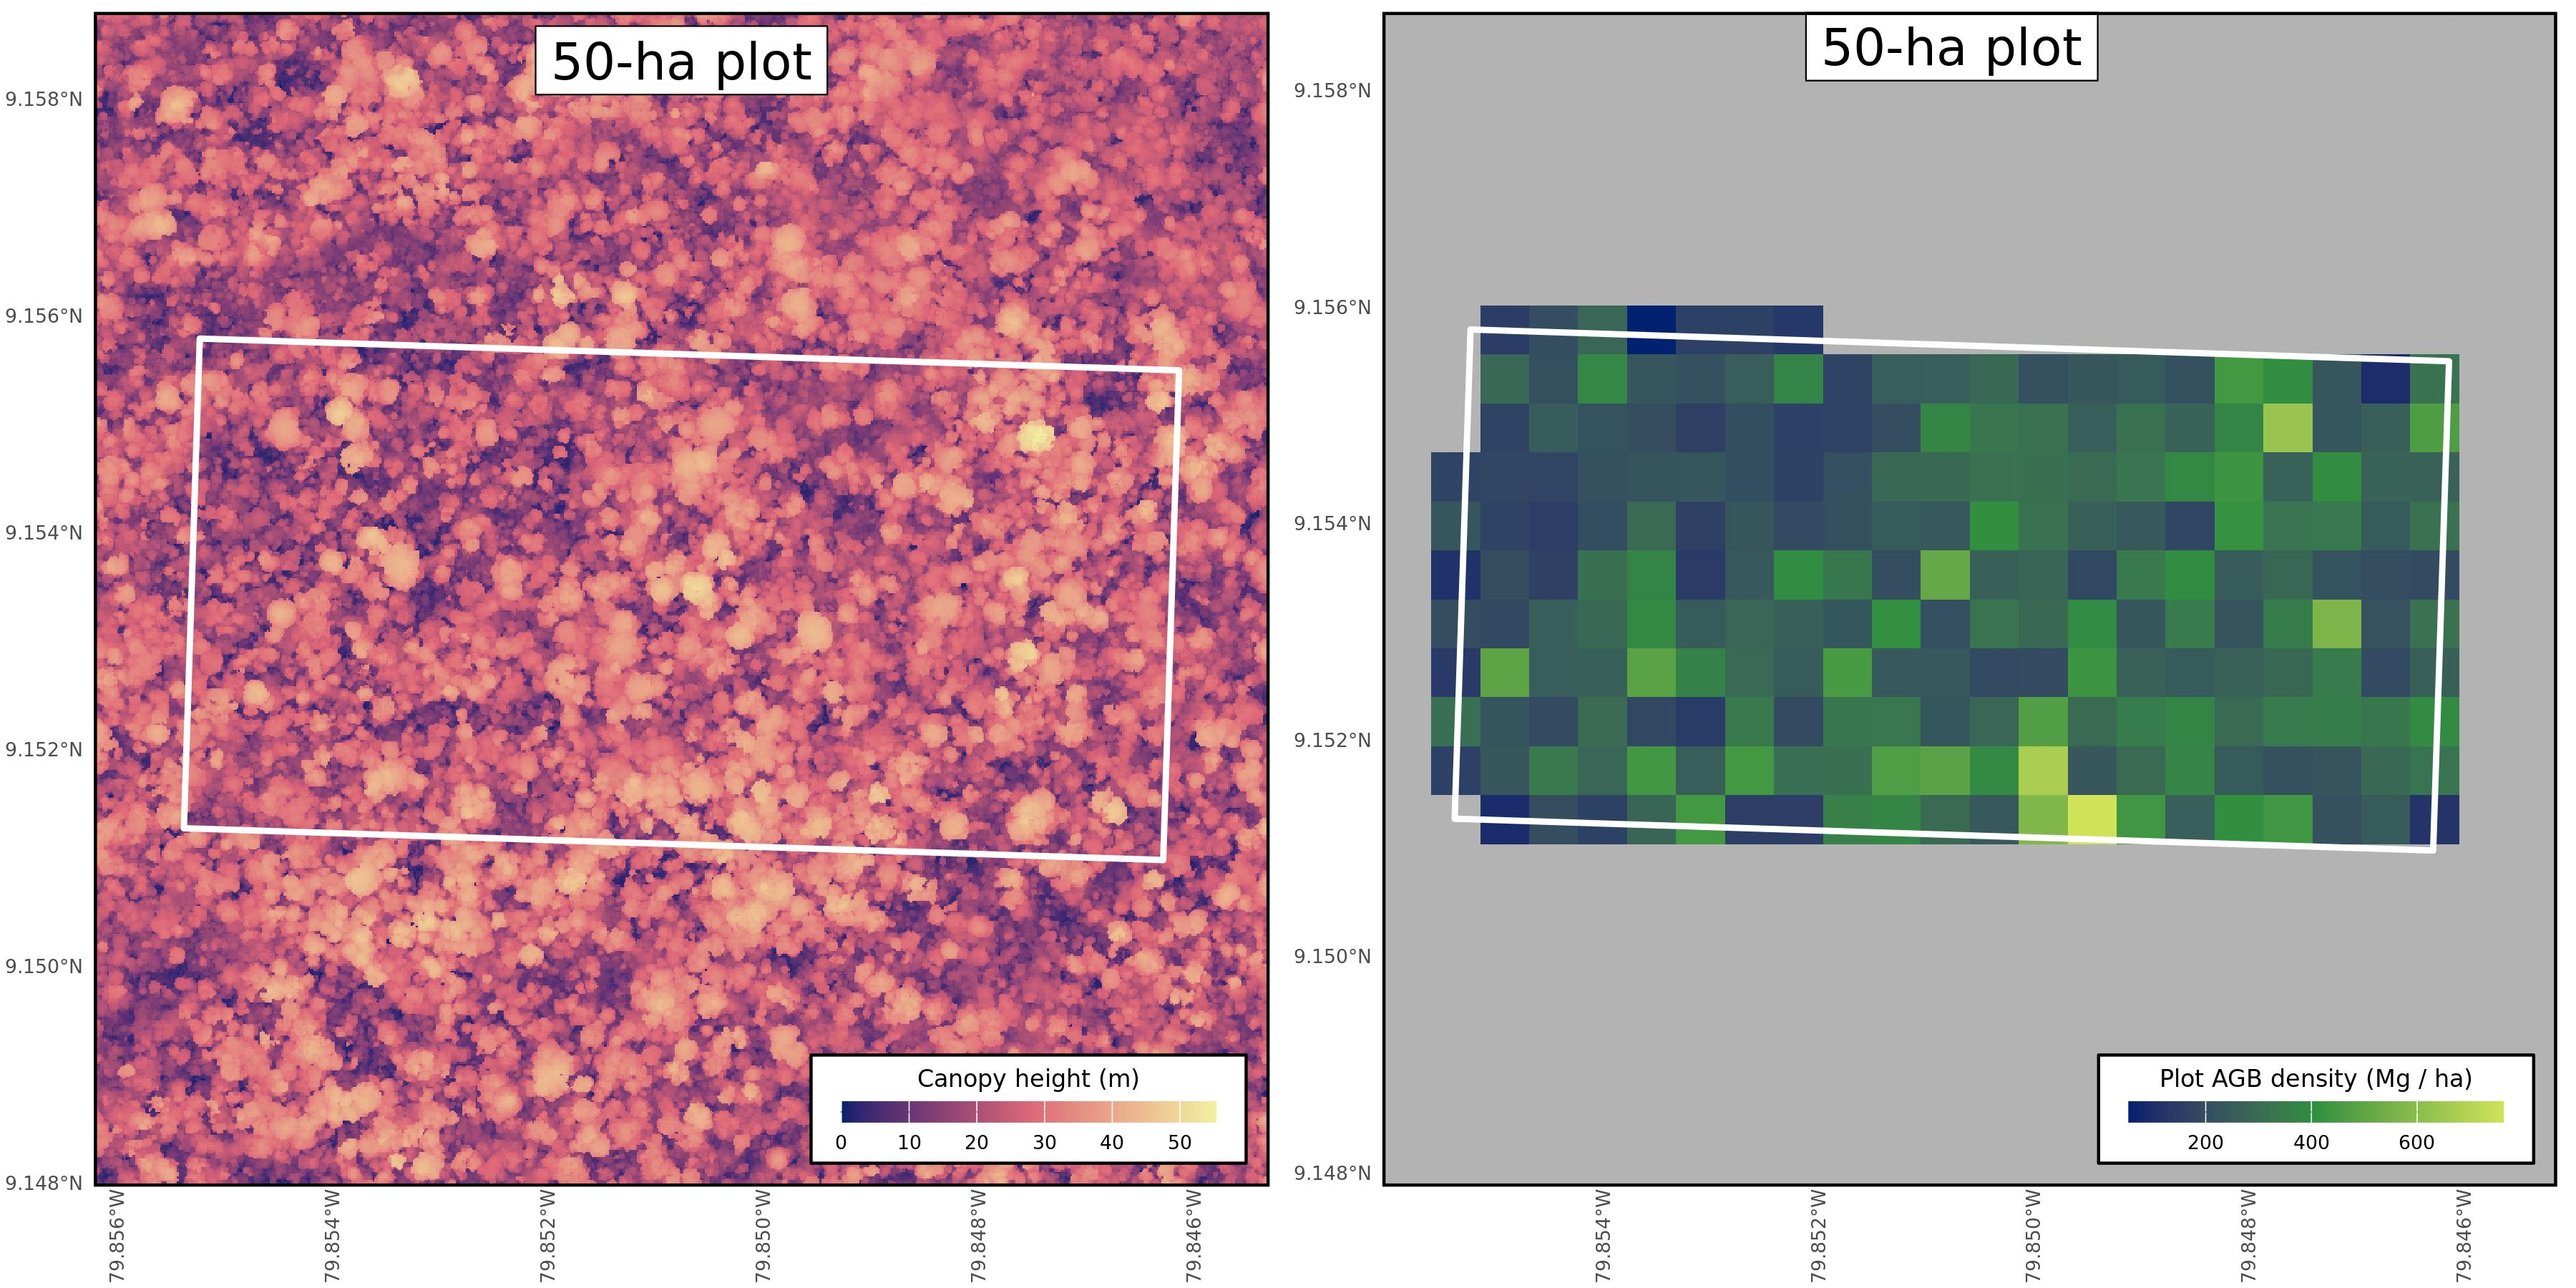

In [28]:
# plot the DTM and CHM for the 50-ha plot

range_DTM <- DTM_smooth |> terra::mask(plots) |> minmax()
range_CHM <- CHM_smooth |> terra::mask(plots) |> minmax()
range_AGB = agb_per_ha |> minmax()

suppressMessages({
    

p1 = ggR(CHM_smooth |> terra::crop(st_buffer(plots_buf_200m[1,], 400)),
               geom_raster = TRUE) +
            scale_fill_gradientn(colors = cols_gradient,
                                na.value = "grey70",
                                limits = c(range_CHM),
                                name = "Canopy height (m)") +
           geom_sf(data = plots[1,], color = "white", fill = NA, linewidth = 1) +
                 geom_sf_label(data = plots[1,],
                            aes(label = NAME),
                            vjust = 1,
                            nudge_y = 585,
                            size = 6, 
                    label.r = unit(0, "pt")) +
            scale_x_continuous(expand = expansion(mult = c(0, 0))) + 
           scale_y_continuous(expand = expansion(mult = c(0, 0))) +
            theme_bw(base_size = 8) +
           theme_map +
            guides(fill = guide_colourbar(title.position="top"))

    p2 = ggR(agb_per_ha |> terra::crop(st_buffer(plots_buf_200m[1,], 400)),
               geom_raster = TRUE) +
            scale_fill_gradientn(colors = cols_gradient_biomass,
                                na.value = "grey70",
                                limits = c(range_AGB),
                                name = "Plot AGB density (Mg / ha)") +
           geom_sf(data = plots[1,], color = "white", fill = NA, linewidth = 1) +
                 geom_sf_label(data = plots_buf_200m[1,],
                            aes(label = NAME),
                            vjust = 1,
                            nudge_y = 585,
                            size = 6, 
                    label.r = unit(0, "pt")) +
            scale_x_continuous(expand = expansion(mult = c(0, 0))) + 
           scale_y_continuous(expand = expansion(mult = c(0, 0))) +
            theme_bw(base_size = 8) +
           theme_map +
            guides(fill = guide_colourbar(title.position="top"))
            })

fig = ggarrange(p1, p2,
        ncol = 2, nrow = 1)

    
ggsave(plot = fig, 
       filename = "./figures/raster/AGB_50ha.jpeg", 
       device = jpeg,
       width = 12,
       height = 6,
       units = "in",
       dpi = 300,
       bg = "white")

IRdisplay::display_jpeg(file = "./figures/raster/AGB_50ha.jpeg") 

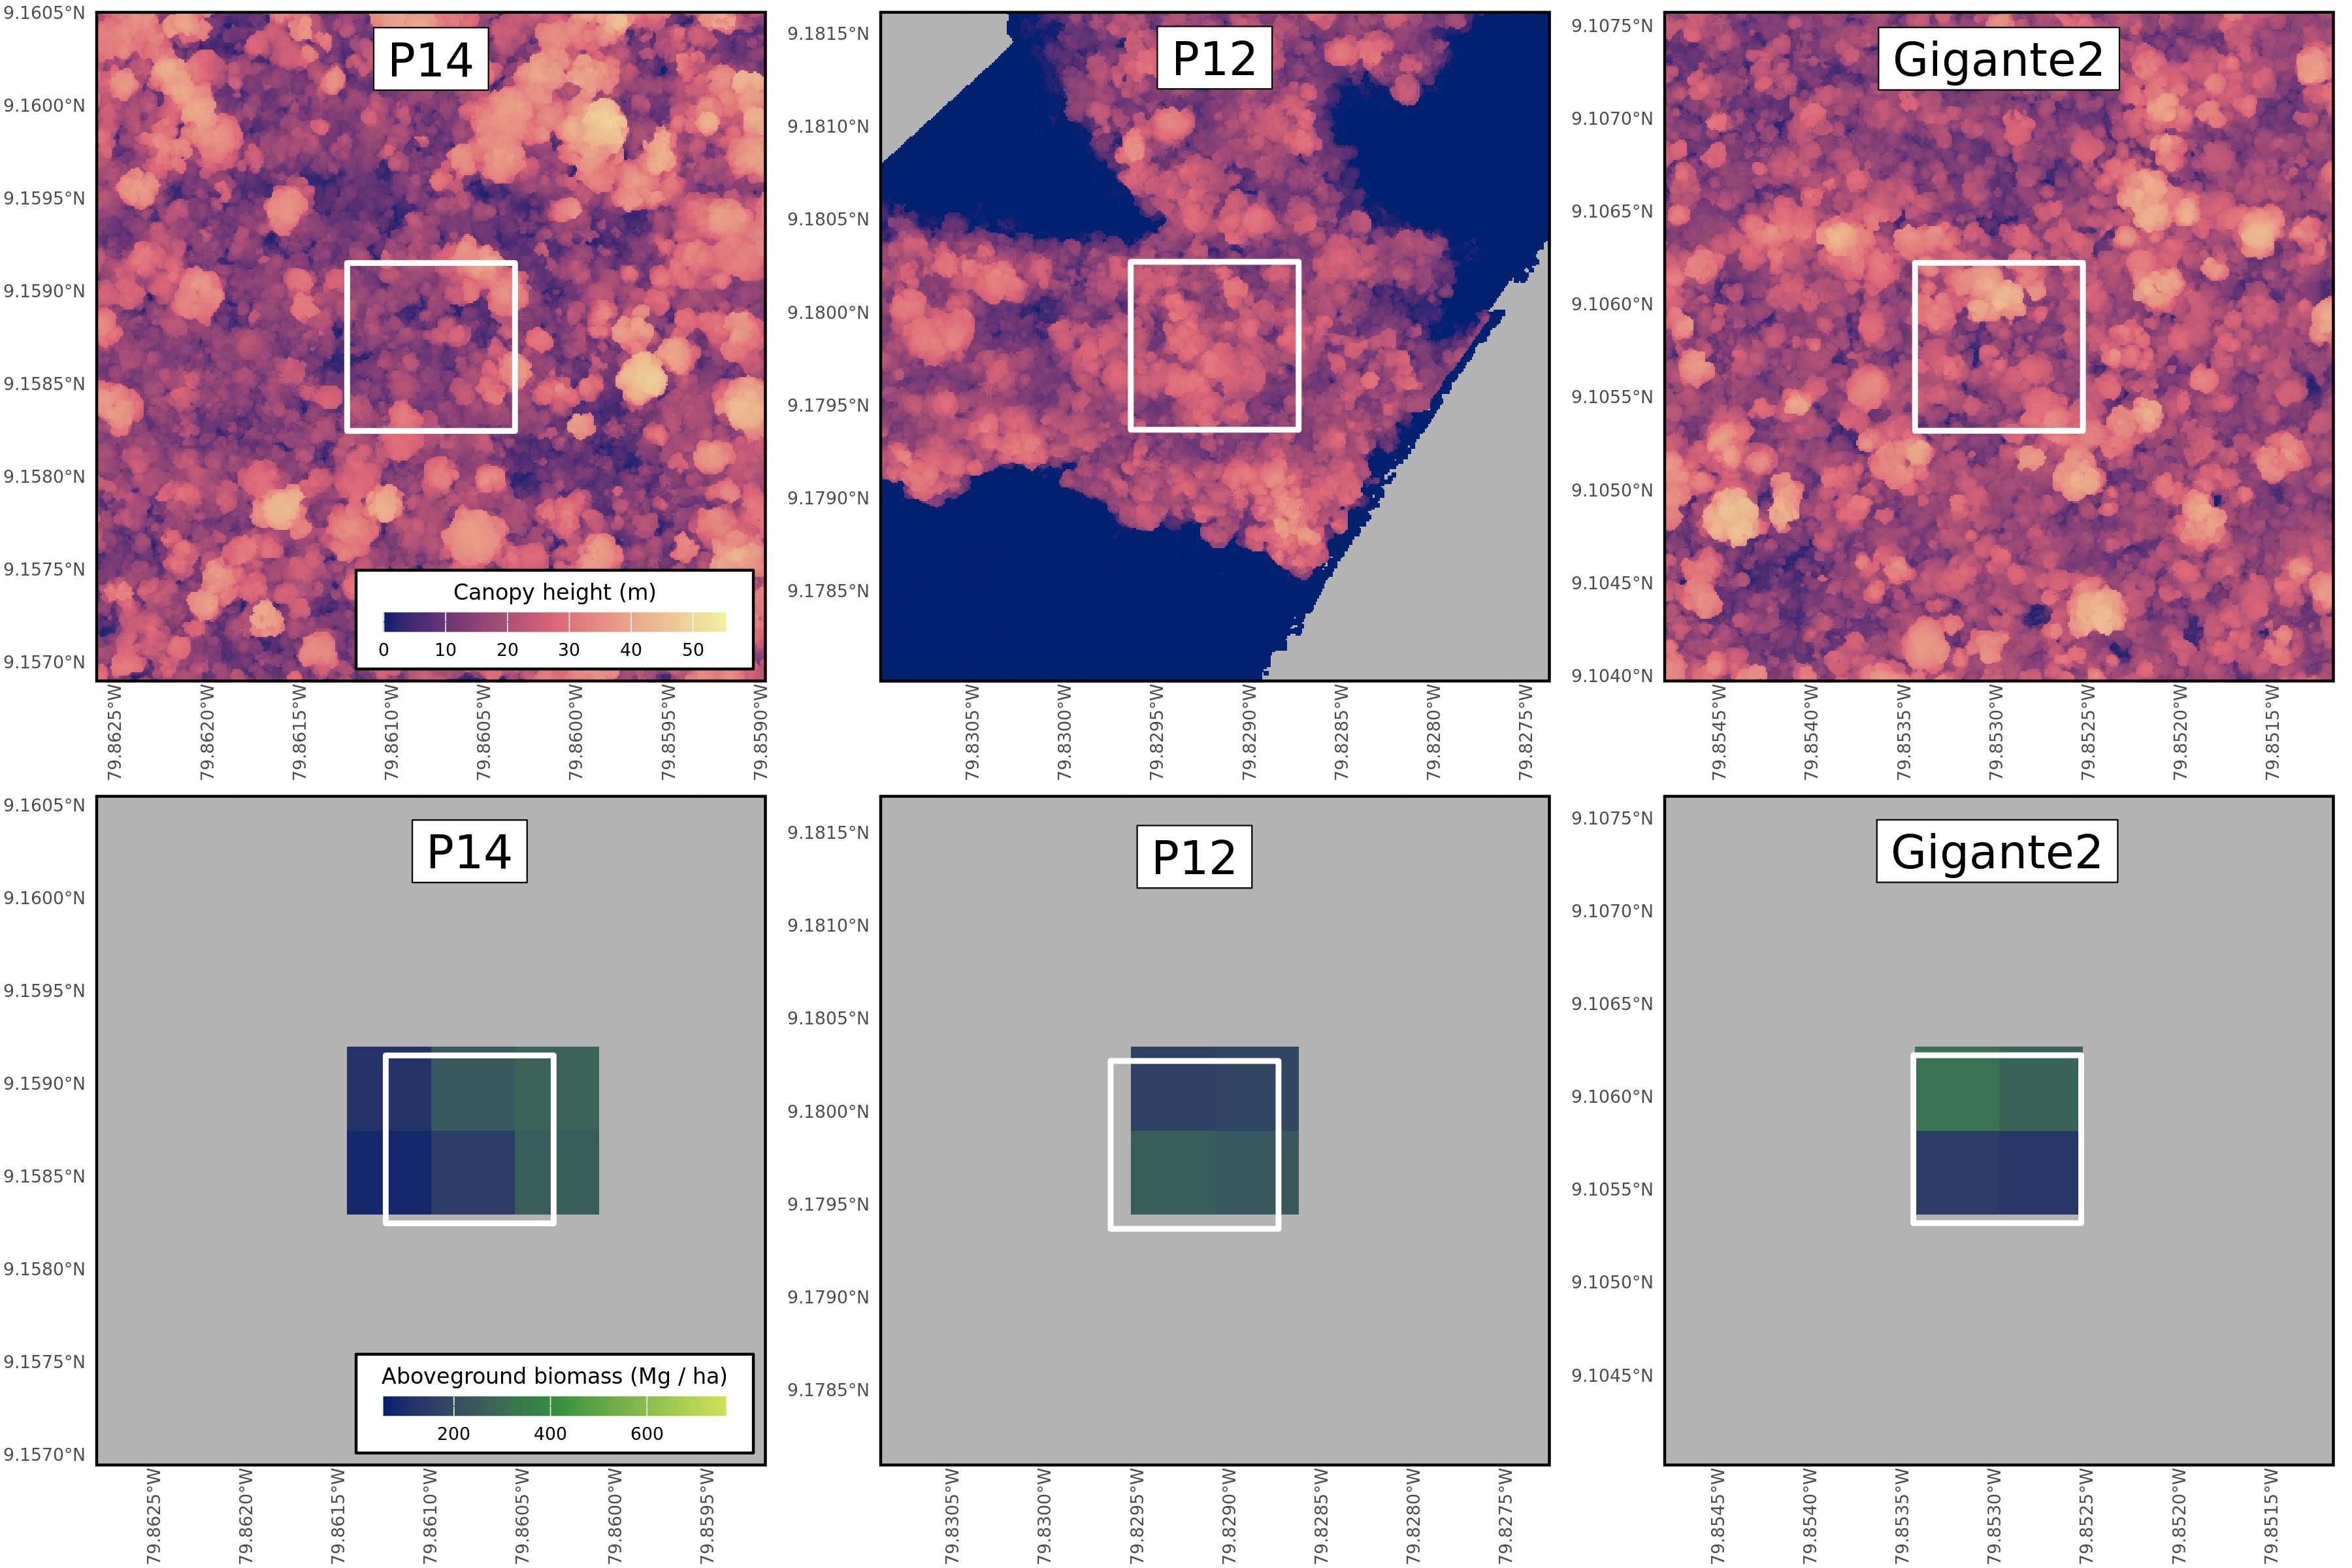

In [29]:
# plot the DTM and CHM for the smaller plots


CHM_list = list()
AGB_list = list()

for (i in 2:4) {

    suppressMessages({

        CHM_list[[i]] = ggR(CHM_smooth |> terra::crop(plots_buf_200m[i,]),
               geom_raster = TRUE) +
            scale_fill_gradientn(colors = cols_gradient,
                                na.value = "grey70",
                                limits = c(range_CHM),
                                name = "Canopy height (m)") +
           geom_sf(data = plots[i,], color = "white", fill = NA, linewidth = 1) +
                 geom_sf_label(data = plots_buf_200m[i,],
                            aes(label = NAME),
                            vjust = 1,
                            nudge_y = 185,
                            size = 6, 
                    label.r = unit(0, "pt")) +
            scale_x_continuous(expand = expansion(mult = c(0, 0))) + 
           scale_y_continuous(expand = expansion(mult = c(0, 0))) +
            theme_bw(base_size = 8) +
           theme_map +
            guides(fill = guide_colourbar(title.position="top"))


         AGB_list[[i]] = ggR(agb_per_ha |> terra::crop(plots_buf_200m[i,]),
               geom_raster = TRUE) +
            scale_fill_gradientn(colors = cols_gradient_biomass,
                                na.value = "grey70",
                                limits = c(range_AGB),
                                name = "Aboveground biomass (Mg / ha)") +
           geom_sf(data = plots[i,], color = "white", fill = NA, linewidth = 1) +
                 geom_sf_label(data = plots_buf_200m[i,],
                            aes(label = NAME),
                            vjust = 1,
                            nudge_y = 185,
                            size = 6, 
                    label.r = unit(0, "pt")) +
            scale_x_continuous(expand = expansion(mult = c(0, 0))) + 
           scale_y_continuous(expand = expansion(mult = c(0, 0))) +
            theme_bw(base_size = 8) +
           theme_map +
            guides(fill = guide_colourbar(title.position="top"))
            })
}


fig = ggarrange(CHM_list[[2]],
                CHM_list[[3]] + guides(fill = "none"), 
                CHM_list[[4]] + guides(fill = "none"),
                AGB_list[[2]],
                AGB_list[[3]] + guides(fill = "none"), 
                AGB_list[[4]] + guides(fill = "none"),
        ncol = 3, nrow = 2)

    
    
ggsave(plot = fig, 
       filename = "./figures/raster/AGB_plots.jpeg", 
       device = jpeg,
       width = 12,
       height = 8,
       units = "in",
       dpi = 300,
       bg = "white")

IRdisplay::display_jpeg(file = "./figures/raster/AGB_plots.jpeg") 


### **8.** Build a model of aboveground biomass from ALS metrics.


In [30]:
# assemble data frame for modeling

preds_50m = rast("./data/ALS/output/_5_metrics_raster/predictors_50m.tif")
AGB_50m = rast("./data/Models/AGB_per_ha_50m.tif")
names(AGB_50m) = c("AGB", "Plot")

AGB_mod = c(preds_50m, AGB_50m)
names(AGB_mod)

AGB_df = as_tibble(AGB_mod) |> drop_na()

# fit a random forests model
rf = randomForest(formula = AGB ~ Z_p99 +
                                  LAI_5m + 
                                  Z_CV + 
                                  Slope + 
                                  Treetops, 
                    data = AGB_df, mtry = 3)
rf

[1] "Z_p99"    "LAI_5m"   "Z_CV"     "Slope"    "Treetops" "AGB"      "Plot"


Call:
 randomForest(formula = AGB ~ Z_p99 + LAI_5m + Z_CV + Slope +      Treetops, data = AGB_df, mtry = 3) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 3

          Mean of squared residuals: 7313.414
                    % Var explained: 34.06


### **9.** Validate the model.


In [31]:

AGB_predict = predict(AGB_mod, rf)
names(AGB_predict) = "AGB_predicted"

AGB_compare = c(AGB_mod, AGB_predict) |>
    as_tibble() |>
    drop_na() |>
    mutate(Plot_size = if_else(Plot == "50-ha plot", Plot, "1-ha plots"))


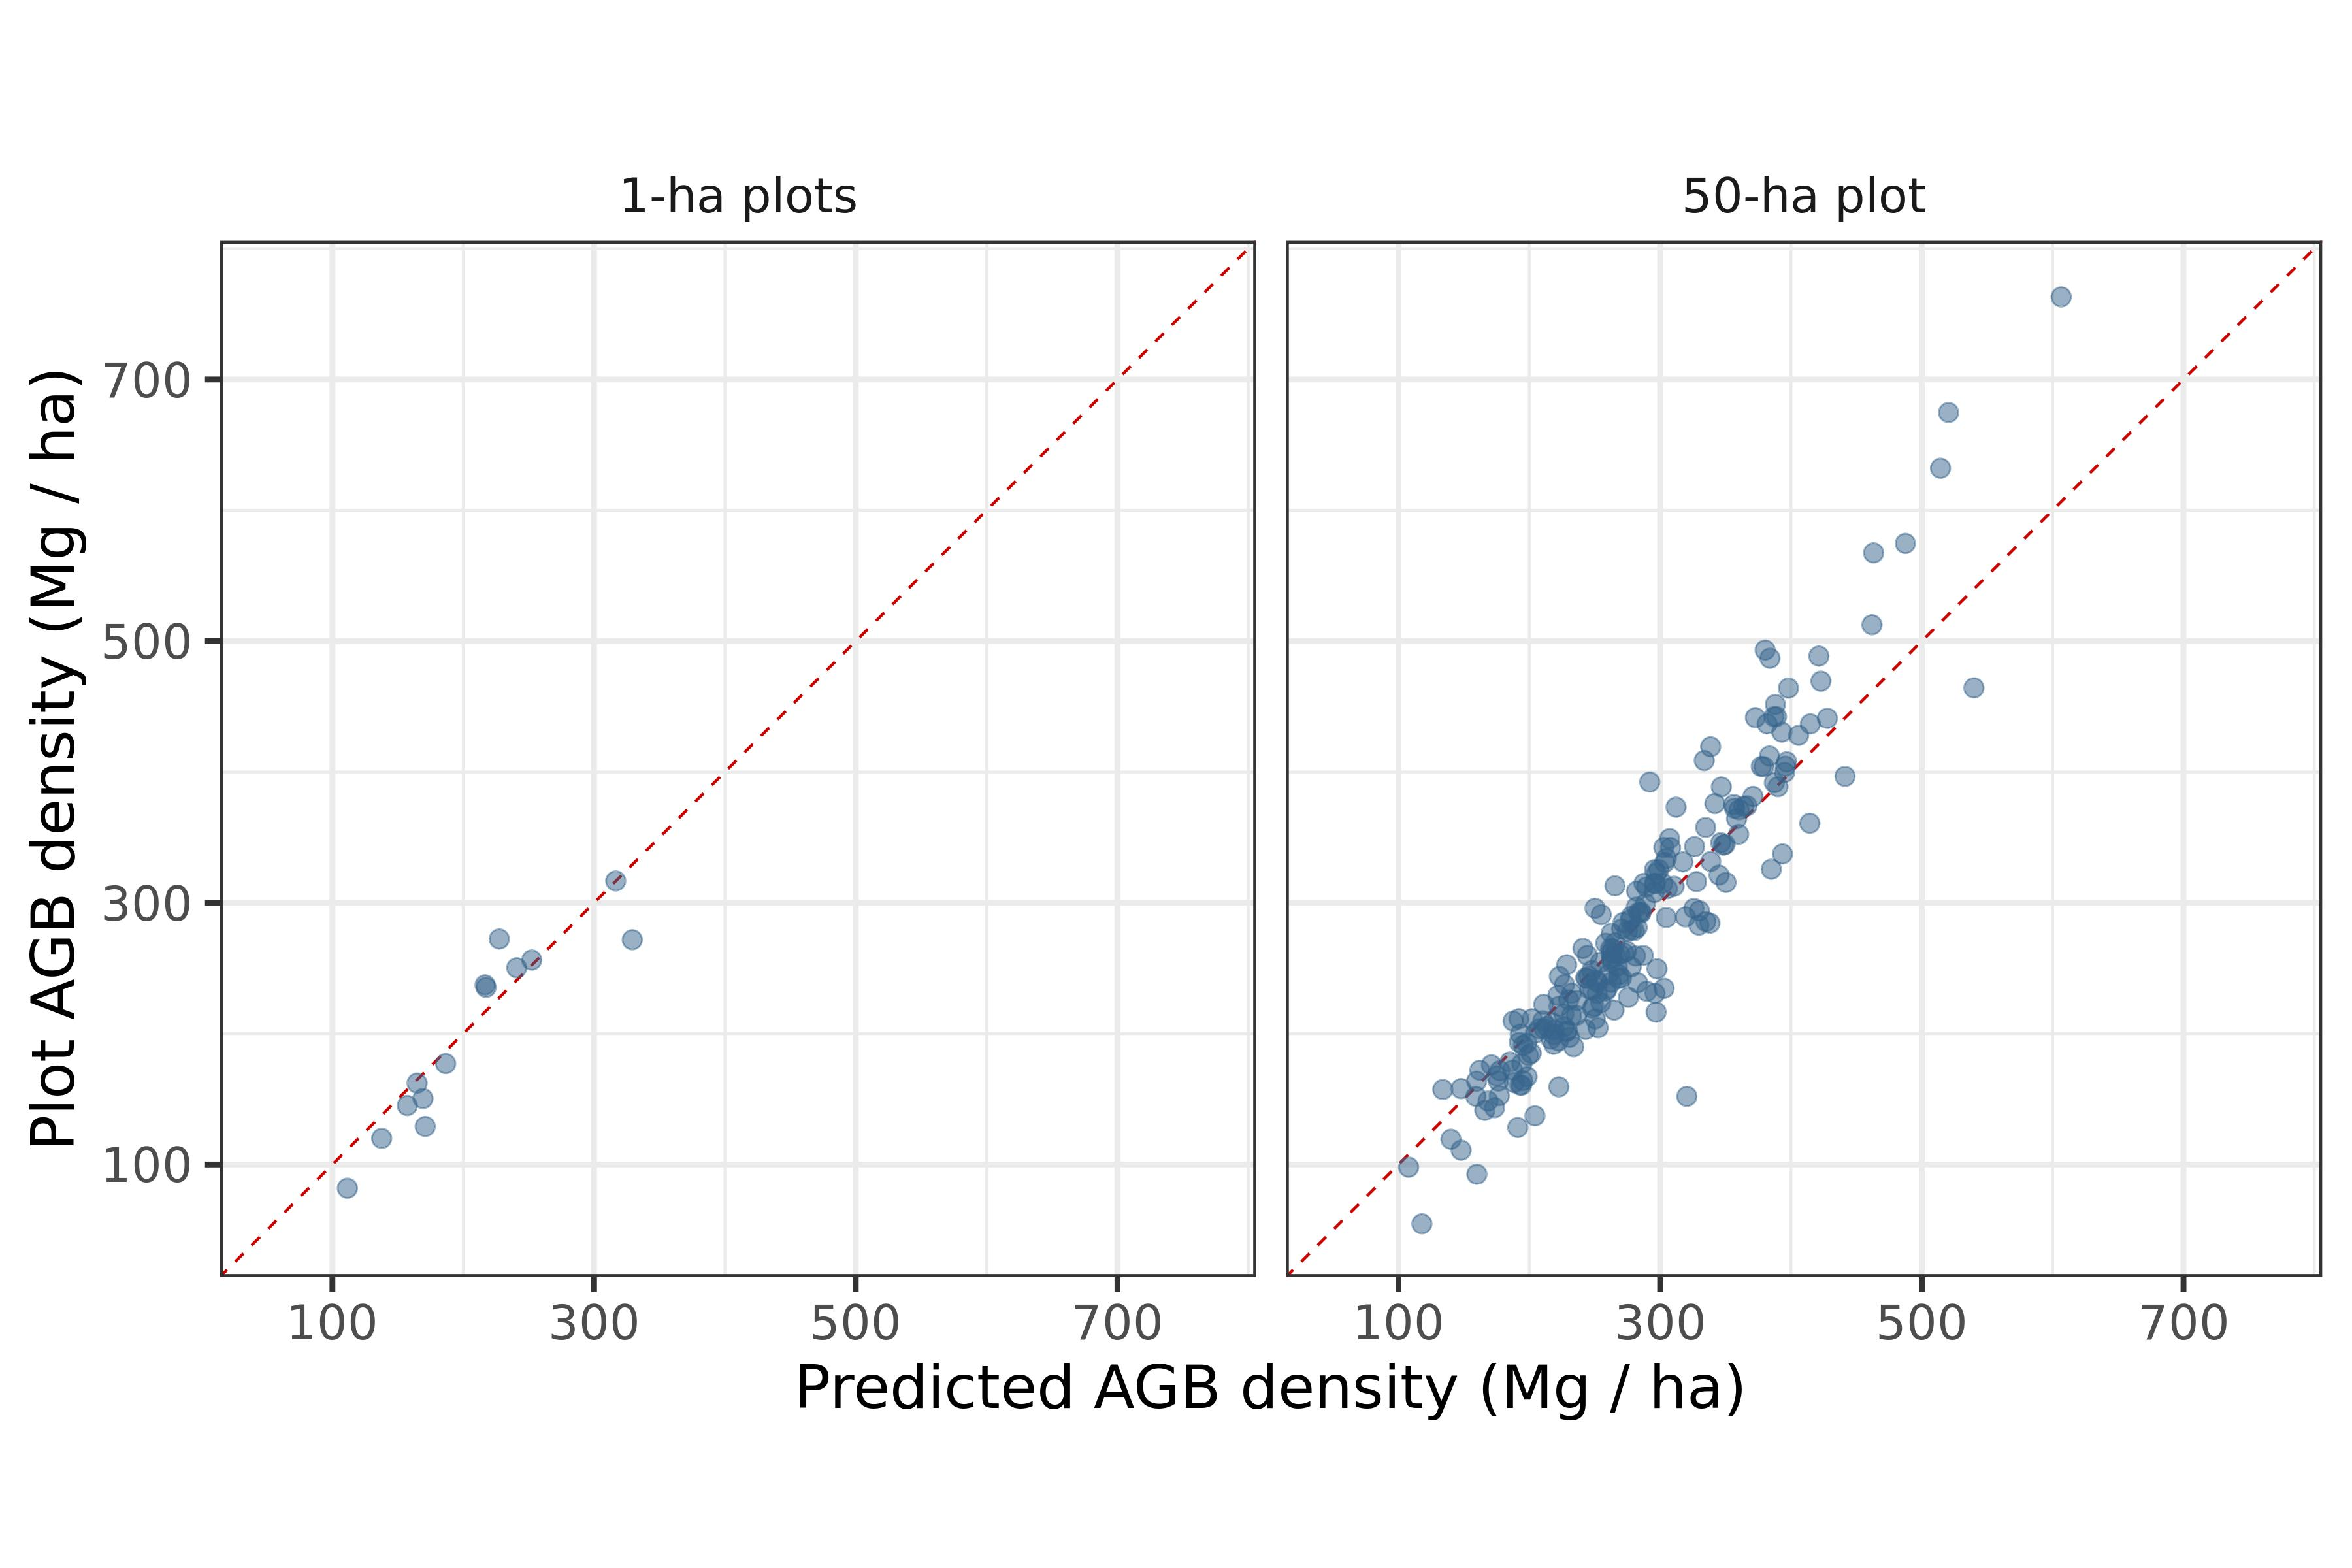

In [32]:
# plot the predictions vs. measured AGB densities

fig = AGB_compare |>
    ggplot(aes(x = AGB_predicted, y = AGB)) +
            geom_abline(slope = 1, linetype = "dashed", color="red3") +
            geom_point(size = 3, color = "steelblue4", alpha = .5) +
            theme_bw(base_size = 22) +
            scale_x_continuous(limits = c(50, 770), breaks = seq(100, 700, 200)) +
            scale_y_continuous(limits = c(50, 770), breaks = seq(100, 700, 200)) +
            theme(aspect.ratio = 1,
                 strip.background = element_blank()) +
            coord_fixed(ratio = 1) +
            labs(x = "Predicted AGB density (Mg / ha)",
                 y = "Plot AGB density (Mg / ha)") +
            facet_grid(. ~ Plot_size)

ggsave(plot = fig, 
       filename = "./figures/models/AGB_predictions.jpeg", 
       device = jpeg,
       width = 12,
       height = 8,
       units = "in",
       dpi = 300,
       bg = "white",
      create.dir = TRUE)

IRdisplay::display_jpeg(file = "./figures/models/AGB_predictions.jpeg") 


### **10** Generate a biomass reference map for the entire ALS acquisition area



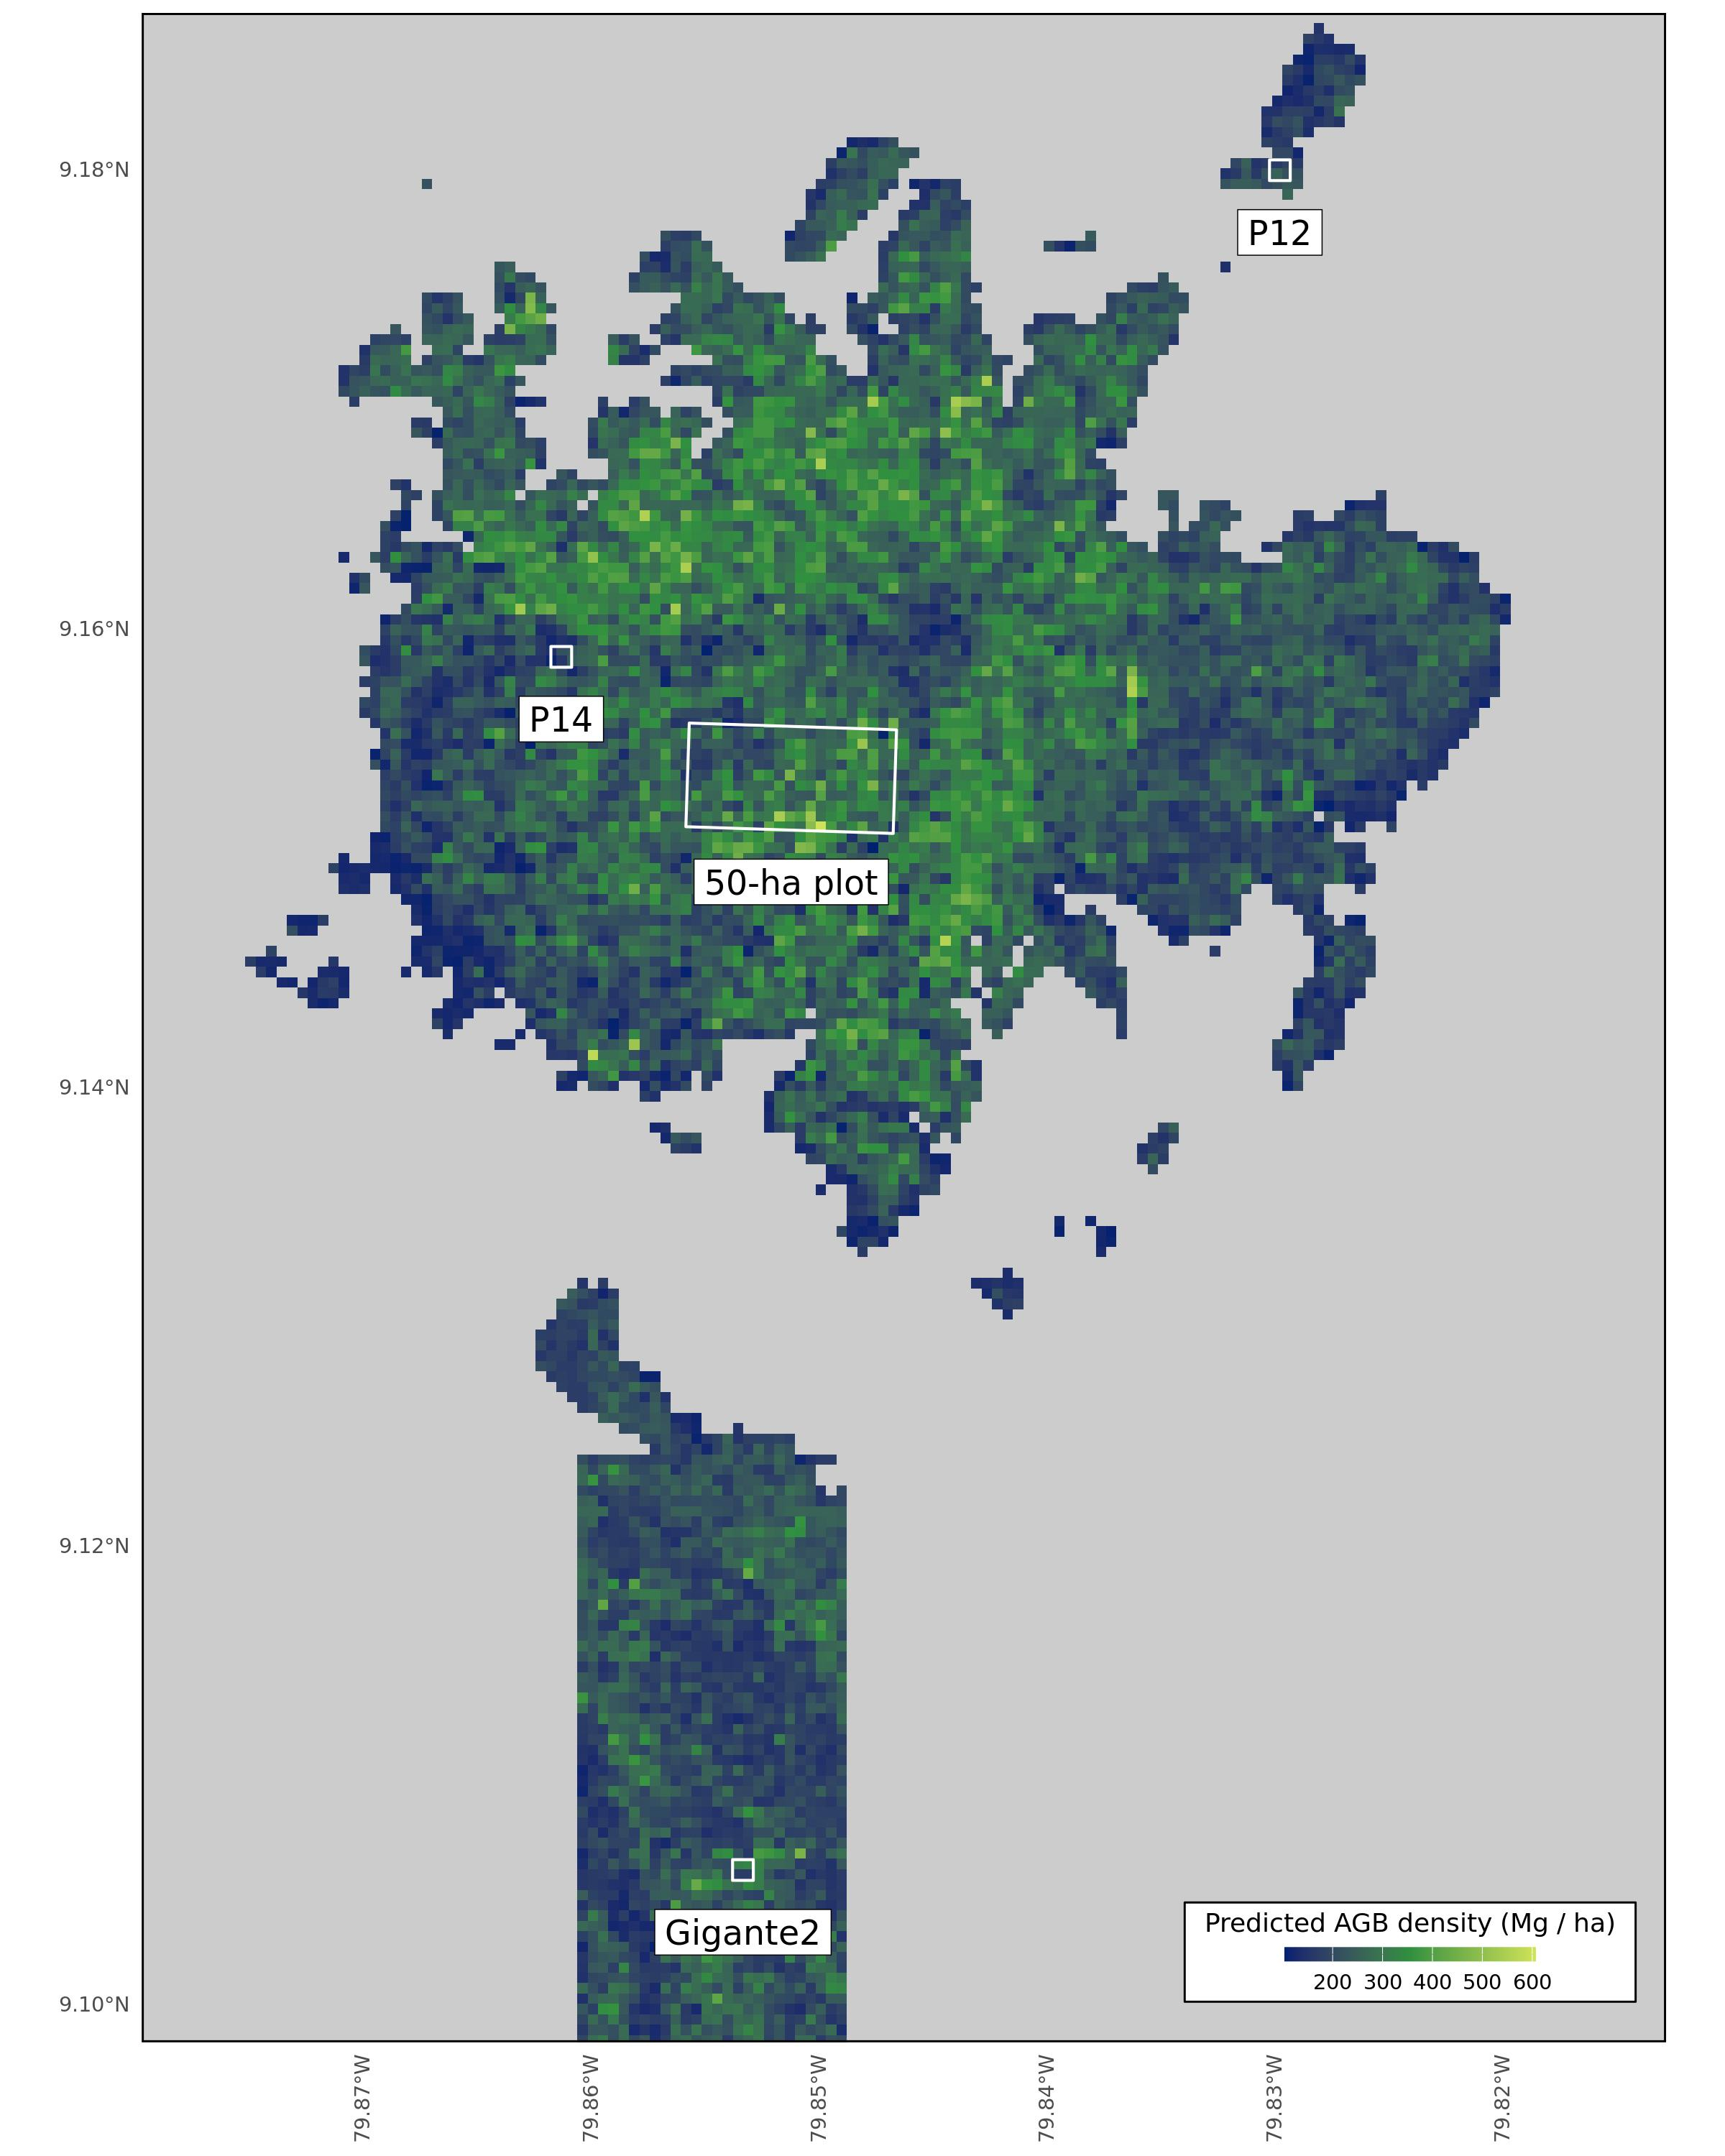

In [33]:
# plot the whole study area 

suppressMessages({

coverage_AGB = ggR(AGB_predict |>
                     clamp(lower = 0),
           geom_raster = TRUE) +
    scale_fill_gradientn(colors = cols_gradient_biomass,
                         na.value = "grey80",
                        # limits = c(range_CHM),
                        name = "Predicted AGB density (Mg / ha)") +
   geom_sf(data = plots, color = "white", fill = NA, linewidth = .7) +
     geom_sf_label(data = plots |> filter(NAME != "50-ha plot"), 
                   aes(label = NAME),
                   nudge_y = -300,
                    size = 6, 
            label.r = unit(0, "pt")) +
      geom_sf_label(data = plots |> filter(NAME == "50-ha plot"), 
                   aes(label = NAME),
                   nudge_y = -500,
                    size = 6, 
            label.r = unit(0, "pt")) +
   scale_x_continuous(expand = expansion(mult = c(0, 0))) + 
   scale_y_continuous(expand = expansion(mult = c(-.16, 0))) +
     theme_bw(base_size = 13) +
   theme_map +
    #coord_sf(crs = 32617) +
    guides(fill = guide_colourbar(title.position="top"))

})
    
ggsave(plot = coverage_AGB, 
       filename = "./figures/raster/AGB_BCI_Gigante.jpeg", 
       device = jpeg,
       width = 12,
       height = 15,
       units = "in",
       dpi = 200,
       bg = "white")

IRdisplay::display_jpeg(file = "./figures/raster/AGB_BCI_Gigante.jpeg") 


**Predicted aboveground biomass (AGB) density for the airborne laser scanning (ALS) acquisition, with field plot boundaries outlined in white. The study area covers all of Barro Colorado Island in the center, a portion of the Buena Vista Peninsula to the north, and a portion of the Gigante Peninsula to the south.**